## 1D-Wave Point


In [ ]:
import os
import time
import torch
import torch.nn as nn
import random
import itertools
import numpy as np
import pandas as pd
from torch.optim import LBFGS
from tqdm import tqdm
from util import get_data, make_time_sequence, get_n_params
from model_dict import get_model

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

def train_model(model_name, learning_rate, hidden_layers, hidden_units,
                device="cpu", max_epochs=1000):
    # Data preparation
    res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 101, 101)
    res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

    # For PINNsFormer models, make time sequences
    if model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
        res = make_time_sequence(res, num_step=5, step=1e-4)
        b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

    # Convert data to tensors
    res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
    b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
    b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
    b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
    b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

    x_res, t_res = res[..., 0:1], res[..., 1:2]
    x_left, t_left = b_left[..., 0:1], b_left[..., 1:2]
    x_right, t_right = b_right[..., 0:1], b_right[..., 1:2]
    x_upper, t_upper = b_upper[..., 0:1], b_upper[..., 1:2]
    x_lower, t_lower = b_lower[..., 0:1], b_lower[..., 1:2]

    # Initialize the model
    ModelClass = get_model(model_name)
    if model_name == 'KAN':
        model = ModelClass(width=[2, 5, 5, 1], grid=5, k=3, grid_eps=1.0,
                           noise_scale_base=0.25, device=device).to(device)
    elif model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
        model = ModelClass(in_dim=2, hidden_dim=32, out_dim=1, num_layer=1).to(device)
    else:
        model = ModelClass(in_dim=2, hidden_dim=hidden_units, out_dim=1,
                           num_layer=hidden_layers).to(device)

    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)
    model.apply(init_weights)

    # Initialize the optimizer
    optimizer = LBFGS(model.parameters(), lr=learning_rate, max_iter=20,
                      history_size=50, line_search_fn='strong_wolfe')

    # Initialize a list to store the loss values
    loss_history = []
    pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

    # Training loop
    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            pred_res = model(x_res, t_res)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)
            pred_upper = model(x_upper, t_upper)
            pred_lower = model(x_lower, t_lower)

            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x),
                                       retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(u_t),
                                       retain_graph=True, create_graph=True)[0]

            loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
            loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

            ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left),
                                       retain_graph=True, create_graph=True)[0]

            loss_ic_1 = torch.mean(
                (pred_left[..., 0] - torch.sin(pi * x_left[..., 0]) - 0.5 * torch.sin(3 * pi * x_left[..., 0])) ** 2)
            loss_ic_2 = torch.mean((ui_t) ** 2)

            loss_ic = loss_ic_1 + loss_ic_2

            loss = loss_res + loss_ic + loss_bc

            # Append the loss value to the history
            loss_history.append(loss.item())

            loss.backward()
            return loss

        optimizer.step(closure)

    # Retrieve the final loss value from the loss history
    final_loss = loss_history[-1]

    # Evaluation
    with torch.no_grad():
        if model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
            res_test = make_time_sequence(res_test, num_step=5, step=1e-4)

        res_test = torch.tensor(res_test, dtype=torch.float32).to(device)
        x_test, t_test = res_test[..., 0:1], res_test[..., 1:2]
        pred = model(x_test, t_test).cpu().detach().numpy()

    pred = pred.reshape(101, 101)

    # Analytical solution
    def u_ana(x, t):
        return np.sin(np.pi * x) * np.cos(2 * np.pi * t) + 0.5 * np.sin(3 * np.pi * x) * np.cos(6 * np.pi * t)

    u = u_ana(res_test.cpu().numpy()[..., 0], res_test.cpu().numpy()[..., 1]).reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u - pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u - pred) ** 2) / np.sum(u ** 2))

    return final_loss, rl1, rl2

def hyperparameter_search(models, param_grid, device="cpu", max_epochs=1000):
    # Create directories for saving results
    results_dir = "./results/wave_point_optimized_results"
    os.makedirs(results_dir, exist_ok=True)
    results_file = os.path.join(results_dir, "hyperparameter_search_results.csv")

    results = []

    # Define hyperparameter keys
    hyperparam_keys = ["learning_rate", "hidden_layers", "hidden_units"]
    hyperparam_values = [param_grid[key] for key in hyperparam_keys]

    # Generate hyperparameter combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    for model_name in models:
        print(f"\nTesting model: {model_name}")
        print(f"Total hyperparameter combinations to test for {model_name}: {len(hyperparam_combinations)}")

        for idx, combination in enumerate(hyperparam_combinations):
            hyperparams = dict(zip(hyperparam_keys, combination))

            train_args = {
                'model_name': model_name,
                'learning_rate': hyperparams["learning_rate"],
                'hidden_layers': hyperparams["hidden_layers"],
                'hidden_units': hyperparams["hidden_units"],
                'device': device,
                'max_epochs': max_epochs,
            }

            print(f"\nTesting combination {idx+1}/{len(hyperparam_combinations)} for model {model_name}: {hyperparams}")
            try:
                start_time = time.time()
                final_loss, rl1, rl2 = train_model(**train_args)
                runtime = time.time() - start_time

                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": final_loss,
                    "relative_L1_error": rl1,
                    "relative_L2_error": rl2,
                    "runtime_seconds": runtime,
                })
                print(f"Model: {model_name}, Final Loss: {final_loss:.6f}, "
                      f"Relative L1 Error: {rl1:.6f}, Relative L2 Error: {rl2:.6f}")

            except Exception as e:
                print(f"Error with combination {hyperparams} for model {model_name}: {e}")
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": None,
                    "relative_L1_error": None,
                    "relative_L2_error": None,
                    "runtime_seconds": None,
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to {results_file}")
    return results_df

if __name__ == "__main__":
    param_grid = {
        "learning_rate": [0.001, 0.01, 0.02],
        "hidden_layers": [2, 4, 6, 8],
        "hidden_units": [128, 256, 512, 1024],
    }
    # List of models to test
    #models = ["PINN", "QRes", "FLS", "KAN", "PINNsFormer", "PINNsFormer_Enc_Only"]
    models = ["PINN"]
    results = hyperparameter_search(models=models, param_grid=param_grid, device="cuda", max_epochs=1000)



Testing model: PINN
Total hyperparameter combinations to test for PINN: 48

Testing combination 1/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128}


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [01:03<00:00, 15.73it/s]


Model: PINN, Final Loss: 0.104198, Relative L1 Error: 0.609446, Relative L2 Error: 0.602705

Testing combination 2/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256}


100%|██████████| 1000/1000 [00:40<00:00, 24.56it/s]


Model: PINN, Final Loss: 0.393464, Relative L1 Error: 1.102078, Relative L2 Error: 1.070918

Testing combination 3/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512}


100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s]


Model: PINN, Final Loss: 0.393518, Relative L1 Error: 1.102352, Relative L2 Error: 1.071134

Testing combination 4/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024}


100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]


Model: PINN, Final Loss: 0.393588, Relative L1 Error: 1.101837, Relative L2 Error: 1.070721

Testing combination 5/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128}


100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]


Model: PINN, Final Loss: 0.096865, Relative L1 Error: 0.515841, Relative L2 Error: 0.509111

Testing combination 6/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256}


100%|██████████| 1000/1000 [02:22<00:00,  7.03it/s]


Model: PINN, Final Loss: 0.141745, Relative L1 Error: 0.776269, Relative L2 Error: 0.767807

Testing combination 7/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512}


100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]


Model: PINN, Final Loss: 0.393394, Relative L1 Error: 1.101546, Relative L2 Error: 1.070529

Testing combination 8/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024}


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]


Model: PINN, Final Loss: 0.393601, Relative L1 Error: 1.101442, Relative L2 Error: 1.070404

Testing combination 9/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 6, 'hidden_units': 128}


100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


Model: PINN, Final Loss: 0.037578, Relative L1 Error: 0.364981, Relative L2 Error: 0.367167

Testing combination 10/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 6, 'hidden_units': 256}


100%|██████████| 1000/1000 [05:39<00:00,  2.94it/s]


Model: PINN, Final Loss: 0.038024, Relative L1 Error: 0.364538, Relative L2 Error: 0.372167

Testing combination 11/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 6, 'hidden_units': 512}


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]


Model: PINN, Final Loss: 0.129112, Relative L1 Error: 0.718856, Relative L2 Error: 0.713880

Testing combination 12/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 6, 'hidden_units': 1024}


100%|██████████| 1000/1000 [11:10<00:00,  1.49it/s]


Model: PINN, Final Loss: 0.393584, Relative L1 Error: 1.101897, Relative L2 Error: 1.070754

Testing combination 13/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 8, 'hidden_units': 128}


100%|██████████| 1000/1000 [03:37<00:00,  4.61it/s]


Model: PINN, Final Loss: 0.089773, Relative L1 Error: 0.549346, Relative L2 Error: 0.553922

Testing combination 14/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 8, 'hidden_units': 256}


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Model: PINN, Final Loss: 0.105669, Relative L1 Error: 0.576226, Relative L2 Error: 0.572229

Testing combination 15/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 8, 'hidden_units': 512}


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Model: PINN, Final Loss: 0.132102, Relative L1 Error: 0.739318, Relative L2 Error: 0.735040

Testing combination 16/48 for model PINN: {'learning_rate': 0.001, 'hidden_layers': 8, 'hidden_units': 1024}


100%|██████████| 1000/1000 [13:08<00:00,  1.27it/s]


Model: PINN, Final Loss: 0.393411, Relative L1 Error: 1.101966, Relative L2 Error: 1.070840

Testing combination 17/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 2, 'hidden_units': 128}


100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]


Model: PINN, Final Loss: 0.089402, Relative L1 Error: 0.491481, Relative L2 Error: 0.481100

Testing combination 18/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 2, 'hidden_units': 256}


100%|██████████| 1000/1000 [01:14<00:00, 13.50it/s]


Model: PINN, Final Loss: 0.092071, Relative L1 Error: 0.501718, Relative L2 Error: 0.491399

Testing combination 19/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 2, 'hidden_units': 512}


100%|██████████| 1000/1000 [01:32<00:00, 10.82it/s]


Model: PINN, Final Loss: 0.092283, Relative L1 Error: 0.502214, Relative L2 Error: 0.491901

Testing combination 20/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 2, 'hidden_units': 1024}


100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]


Model: PINN, Final Loss: 0.082914, Relative L1 Error: 0.491516, Relative L2 Error: 0.479743

Testing combination 21/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 4, 'hidden_units': 128}


100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


Model: PINN, Final Loss: 0.018407, Relative L1 Error: 0.313438, Relative L2 Error: 0.321516

Testing combination 22/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 4, 'hidden_units': 256}


100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


Model: PINN, Final Loss: 0.027889, Relative L1 Error: 0.353177, Relative L2 Error: 0.371113

Testing combination 23/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 4, 'hidden_units': 512}


100%|██████████| 1000/1000 [05:26<00:00,  3.06it/s]


Model: PINN, Final Loss: 0.022011, Relative L1 Error: 0.341249, Relative L2 Error: 0.347911

Testing combination 24/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 4, 'hidden_units': 1024}


100%|██████████| 1000/1000 [10:54<00:00,  1.53it/s]


Model: PINN, Final Loss: 0.097432, Relative L1 Error: 0.527581, Relative L2 Error: 0.518368

Testing combination 25/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 6, 'hidden_units': 128}


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Model: PINN, Final Loss: 0.020737, Relative L1 Error: 0.340927, Relative L2 Error: 0.345325

Testing combination 26/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 6, 'hidden_units': 256}


100%|██████████| 1000/1000 [11:24<00:00,  1.46it/s]


Model: PINN, Final Loss: 0.007998, Relative L1 Error: 0.172220, Relative L2 Error: 0.181658

Testing combination 27/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 6, 'hidden_units': 512}


100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


Model: PINN, Final Loss: 0.039963, Relative L1 Error: 0.401262, Relative L2 Error: 0.398176

Testing combination 28/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 6, 'hidden_units': 1024}


100%|██████████| 1000/1000 [32:45<00:00,  1.97s/it]


Model: PINN, Final Loss: 0.028304, Relative L1 Error: 0.385739, Relative L2 Error: 0.389364

Testing combination 29/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 8, 'hidden_units': 128}


100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


Model: PINN, Final Loss: 0.015730, Relative L1 Error: 0.297861, Relative L2 Error: 0.305517

Testing combination 30/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 8, 'hidden_units': 256}


100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]


Model: PINN, Final Loss: 0.021384, Relative L1 Error: 0.345532, Relative L2 Error: 0.349188

Testing combination 31/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 8, 'hidden_units': 512}


100%|██████████| 1000/1000 [18:43<00:00,  1.12s/it]


Model: PINN, Final Loss: 0.025669, Relative L1 Error: 0.378680, Relative L2 Error: 0.380289

Testing combination 32/48 for model PINN: {'learning_rate': 0.01, 'hidden_layers': 8, 'hidden_units': 1024}


100%|██████████| 1000/1000 [38:46<00:00,  2.33s/it]


Model: PINN, Final Loss: 0.023821, Relative L1 Error: 0.307928, Relative L2 Error: 0.317063

Testing combination 33/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 2, 'hidden_units': 128}


100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


Model: PINN, Final Loss: 0.019925, Relative L1 Error: 0.354504, Relative L2 Error: 0.359871

Testing combination 34/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 2, 'hidden_units': 256}


100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


Model: PINN, Final Loss: 0.030360, Relative L1 Error: 0.346396, Relative L2 Error: 0.348459

Testing combination 35/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 2, 'hidden_units': 512}


100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Model: PINN, Final Loss: 0.093588, Relative L1 Error: 0.500617, Relative L2 Error: 0.490293

Testing combination 36/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 2, 'hidden_units': 1024}


100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]


Model: PINN, Final Loss: 0.093693, Relative L1 Error: 0.499320, Relative L2 Error: 0.489008

Testing combination 37/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 4, 'hidden_units': 128}


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


Model: PINN, Final Loss: 0.008211, Relative L1 Error: 0.165870, Relative L2 Error: 0.177597

Testing combination 38/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 4, 'hidden_units': 256}


100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


Model: PINN, Final Loss: 0.010850, Relative L1 Error: 0.228054, Relative L2 Error: 0.243407

Testing combination 39/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 4, 'hidden_units': 512}


100%|██████████| 1000/1000 [12:18<00:00,  1.35it/s]


Model: PINN, Final Loss: 0.005010, Relative L1 Error: 0.123708, Relative L2 Error: 0.135198

Testing combination 40/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 4, 'hidden_units': 1024}


100%|██████████| 1000/1000 [22:21<00:00,  1.34s/it]


Model: PINN, Final Loss: 0.011310, Relative L1 Error: 0.218104, Relative L2 Error: 0.227848

Testing combination 41/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 6, 'hidden_units': 128}


100%|██████████| 1000/1000 [08:16<00:00,  2.01it/s]


Model: PINN, Final Loss: 0.003160, Relative L1 Error: 0.096566, Relative L2 Error: 0.102616

Testing combination 42/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 6, 'hidden_units': 256}


100%|██████████| 1000/1000 [10:11<00:00,  1.64it/s]


Model: PINN, Final Loss: 0.009609, Relative L1 Error: 0.198922, Relative L2 Error: 0.208928

Testing combination 43/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 6, 'hidden_units': 512}


100%|██████████| 1000/1000 [14:42<00:00,  1.13it/s]


Model: PINN, Final Loss: 0.006931, Relative L1 Error: 0.153063, Relative L2 Error: 0.160707

Testing combination 44/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 6, 'hidden_units': 1024}


100%|██████████| 1000/1000 [57:46<00:00,  3.47s/it]


Model: PINN, Final Loss: 0.011848, Relative L1 Error: 0.227718, Relative L2 Error: 0.237493

Testing combination 45/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 8, 'hidden_units': 128}


100%|██████████| 1000/1000 [06:20<00:00,  2.62it/s]


Model: PINN, Final Loss: 0.020950, Relative L1 Error: 0.342972, Relative L2 Error: 0.350565

Testing combination 46/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 8, 'hidden_units': 256}


100%|██████████| 1000/1000 [13:56<00:00,  1.19it/s]


Model: PINN, Final Loss: 0.015772, Relative L1 Error: 0.294803, Relative L2 Error: 0.305898

Testing combination 47/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 8, 'hidden_units': 512}


100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s]


Model: PINN, Final Loss: 0.019153, Relative L1 Error: 0.318888, Relative L2 Error: 0.327194

Testing combination 48/48 for model PINN: {'learning_rate': 0.02, 'hidden_layers': 8, 'hidden_units': 1024}


100%|██████████| 1000/1000 [1:02:41<00:00,  3.76s/it]

Model: PINN, Final Loss: 0.020544, Relative L1 Error: 0.341850, Relative L2 Error: 0.351188

Results saved to ./results/wave_point_optimized_results/hyperparameter_search_results.csv


In [ ]:
import os
import time
import torch
import torch.nn as nn
import random
import itertools
import numpy as np
import pandas as pd
from torch.optim import LBFGS
from tqdm import tqdm
from util import get_data, make_time_sequence, get_n_params
from model_dict import get_model

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

def train_model(model_name, learning_rate, hidden_layers, hidden_units,
                device="cpu", max_epochs=1000):
    # Data preparation
    res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 101, 101)
    res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

    # For PINNsFormer models, make time sequences
    if model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
        res = make_time_sequence(res, num_step=5, step=1e-4)
        b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

    # Convert data to tensors
    res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
    b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
    b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
    b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
    b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

    x_res, t_res = res[..., 0:1], res[..., 1:2]
    x_left, t_left = b_left[..., 0:1], b_left[..., 1:2]
    x_right, t_right = b_right[..., 0:1], b_right[..., 1:2]
    x_upper, t_upper = b_upper[..., 0:1], b_upper[..., 1:2]
    x_lower, t_lower = b_lower[..., 0:1], b_lower[..., 1:2]

    # Initialize the model
    ModelClass = get_model(model_name)
    if model_name == 'KAN':
        model = ModelClass(width=[2, 5, 5, 1], grid=5, k=3, grid_eps=1.0,
                           noise_scale_base=0.25, device=device).to(device)
    elif model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
        model = ModelClass(in_dim=2, hidden_dim=32, out_dim=1, num_layer=1).to(device)
    else:
        model = ModelClass(in_dim=2, hidden_dim=hidden_units, out_dim=1,
                           num_layer=hidden_layers).to(device)

    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)
    model.apply(init_weights)

    # Initialize the optimizer
    optimizer = LBFGS(model.parameters(), lr=learning_rate, max_iter=20,
                      history_size=50, line_search_fn='strong_wolfe')

    # Initialize a list to store the loss values
    loss_history = []
    pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

    # Training loop
    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            pred_res = model(x_res, t_res)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)
            pred_upper = model(x_upper, t_upper)
            pred_lower = model(x_lower, t_lower)

            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x),
                                       retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(u_t),
                                       retain_graph=True, create_graph=True)[0]

            loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
            loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

            ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left),
                                       retain_graph=True, create_graph=True)[0]

            loss_ic_1 = torch.mean(
                (pred_left[..., 0] - torch.sin(pi * x_left[..., 0]) - 0.5 * torch.sin(3 * pi * x_left[..., 0])) ** 2)
            loss_ic_2 = torch.mean((ui_t) ** 2)

            loss_ic = loss_ic_1 + loss_ic_2

            loss = loss_res + loss_ic + loss_bc

            # Append the loss value to the history
            loss_history.append(loss.item())

            loss.backward()
            return loss

        optimizer.step(closure)

    # Retrieve the final loss value from the loss history
    final_loss = loss_history[-1]

    # Evaluation
    with torch.no_grad():
        if model_name == 'PINNsFormer' or model_name == 'PINNsFormer_Enc_Only':
            res_test = make_time_sequence(res_test, num_step=5, step=1e-4)

        res_test = torch.tensor(res_test, dtype=torch.float32).to(device)
        x_test, t_test = res_test[..., 0:1], res_test[..., 1:2]
        pred = model(x_test, t_test).cpu().detach().numpy()

    pred = pred.reshape(101, 101)

    # Analytical solution
    def u_ana(x, t):
        return np.sin(np.pi * x) * np.cos(2 * np.pi * t) + 0.5 * np.sin(3 * np.pi * x) * np.cos(6 * np.pi * t)

    u = u_ana(res_test.cpu().numpy()[..., 0], res_test.cpu().numpy()[..., 1]).reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u - pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u - pred) ** 2) / np.sum(u ** 2))

    return final_loss, rl1, rl2

def hyperparameter_search(models, param_grid, device="cpu", max_epochs=1000):
    # Create directories for saving results
    results_dir = "./results/wave_point_optimized_results"
    os.makedirs(results_dir, exist_ok=True)
    results_file = os.path.join(results_dir, "hyperparameter_search_results.csv")

    results = []

    # Define hyperparameter keys
    hyperparam_keys = ["learning_rate", "hidden_layers", "hidden_units"]
    hyperparam_values = [param_grid[key] for key in hyperparam_keys]

    # Generate hyperparameter combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    for model_name in models:
        print(f"\nTesting model: {model_name}")
        print(f"Total hyperparameter combinations to test for {model_name}: {len(hyperparam_combinations)}")

        for idx, combination in enumerate(hyperparam_combinations):
            hyperparams = dict(zip(hyperparam_keys, combination))

            train_args = {
                'model_name': model_name,
                'learning_rate': hyperparams["learning_rate"],
                'hidden_layers': hyperparams["hidden_layers"],
                'hidden_units': hyperparams["hidden_units"],
                'device': device,
                'max_epochs': max_epochs,
            }

            print(f"\nTesting combination {idx+1}/{len(hyperparam_combinations)} for model {model_name}: {hyperparams}")
            try:
                start_time = time.time()
                final_loss, rl1, rl2 = train_model(**train_args)
                runtime = time.time() - start_time

                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": final_loss,
                    "relative_L1_error": rl1,
                    "relative_L2_error": rl2,
                    "runtime_seconds": runtime,
                })
                print(f"Model: {model_name}, Final Loss: {final_loss:.6f}, "
                      f"Relative L1 Error: {rl1:.6f}, Relative L2 Error: {rl2:.6f}")

            except Exception as e:
                print(f"Error with combination {hyperparams} for model {model_name}: {e}")
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": None,
                    "relative_L1_error": None,
                    "relative_L2_error": None,
                    "runtime_seconds": None,
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to {results_file}")
    return results_df

if __name__ == "__main__":
    param_grid = {
        "learning_rate": [0.0001],
        "hidden_layers": [2, 4],
        "hidden_units": [128, 256, 512, 1024],
    }
    # List of models to test
    #models = ["PINN", "QRes", "FLS", "KAN", "PINNsFormer", "PINNsFormer_Enc_Only"]
    models = ["PINN"]
    results = hyperparameter_search(models=models, param_grid=param_grid, device="cuda", max_epochs=1000)



Testing model: PINN
Total hyperparameter combinations to test for PINN: 8

Testing combination 1/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128}


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [00:31<00:00, 31.36it/s]


Model: PINN, Final Loss: 0.393004, Relative L1 Error: 1.100893, Relative L2 Error: 1.070027

Testing combination 2/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256}


100%|██████████| 1000/1000 [00:31<00:00, 31.84it/s]


Model: PINN, Final Loss: 0.393572, Relative L1 Error: 1.102304, Relative L2 Error: 1.071079

Testing combination 3/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512}


100%|██████████| 1000/1000 [00:41<00:00, 24.01it/s]


Model: PINN, Final Loss: 0.393639, Relative L1 Error: 1.103397, Relative L2 Error: 1.071902

Testing combination 4/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024}


100%|██████████| 1000/1000 [00:48<00:00, 20.58it/s]


Model: PINN, Final Loss: 0.393679, Relative L1 Error: 1.101556, Relative L2 Error: 1.070476

Testing combination 5/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128}


100%|██████████| 1000/1000 [01:29<00:00, 11.11it/s]


Model: PINN, Final Loss: 0.147552, Relative L1 Error: 0.801746, Relative L2 Error: 0.789447

Testing combination 6/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256}


100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


Model: PINN, Final Loss: 0.393120, Relative L1 Error: 1.102266, Relative L2 Error: 1.071163

Testing combination 7/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512}


100%|██████████| 1000/1000 [01:52<00:00,  8.93it/s]


Model: PINN, Final Loss: 0.393573, Relative L1 Error: 1.102808, Relative L2 Error: 1.071513

Testing combination 8/8 for model PINN: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024}


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]

Model: PINN, Final Loss: 0.393758, Relative L1 Error: 1.101129, Relative L2 Error: 1.070084

Results saved to ./results/wave_point_optimized_results/hyperparameter_search_results.csv


## 1-D Wave Region

In [ ]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
from tqdm import tqdm
import pandas as pd
from util import get_data, make_time_sequence, get_n_params
from model_dict import get_model

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Check for CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def u_ana_fn(x, t):
    # Analytical solution: u(x,t)=sin(pi*x)*cos(2*pi*t)+0.5*sin(3*pi*x)*cos(6*pi*t)
    return np.sin(np.pi*x)*np.cos(2*np.pi*t) + 0.5*np.sin(3*np.pi*x)*np.cos(6*np.pi*t)

def train_model(model_name, learning_rate, hidden_layers, hidden_units,
                initial_region, sample_num, past_iterations,
                device="cpu", max_epochs=500):
    # Data preparation
    res, b_left, b_right, b_upper, b_lower = get_data([0,1],[0,1],101,101)
    res_test, _, _, _, _ = get_data([0,1],[0,1],101,101)

    # For PINNsFormer models, make time sequences
    if model_name in ['PINNsFormer', 'PINNsFormer_Enc_Only']:
        res = make_time_sequence(res, num_step=5, step=1e-4)
        b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

    # Convert data to tensors (double precision)
    res = torch.tensor(res, dtype=torch.float64, requires_grad=True).to(device)
    b_left = torch.tensor(b_left, dtype=torch.float64, requires_grad=True).to(device)
    b_right = torch.tensor(b_right, dtype=torch.float64, requires_grad=True).to(device)
    b_upper = torch.tensor(b_upper, dtype=torch.float64, requires_grad=True).to(device)
    b_lower = torch.tensor(b_lower, dtype=torch.float64, requires_grad=True).to(device)

    x_res, t_res = res[...,0:1], res[...,1:2]
    x_left, t_left = b_left[...,0:1], b_left[...,1:2]
    x_right, t_right = b_right[...,0:1], b_right[...,1:2]
    x_upper, t_upper = b_upper[...,0:1], b_upper[...,1:2]
    x_lower, t_lower = b_lower[...,0:1], b_lower[...,1:2]

    # Initialize model
    ModelClass = get_model(model_name)
    if model_name == 'KAN':
        model = ModelClass(width=[2,5,5,1], grid=5, k=3, grid_eps=1.0,
                           noise_scale_base=0.25, device=device).to(device).double()
    elif model_name in ['PINNsFormer','PINNsFormer_Enc_Only']:
        model = ModelClass(in_dim=2, hidden_dim=32, out_dim=1, num_layer=1).to(device).double()
    else:
        model = ModelClass(in_dim=2, hidden_dim=hidden_units, out_dim=1, num_layer=hidden_layers).to(device).double()

    model.apply(init_weights)

    # Use LBFGS optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=20,
                                  history_size=50, line_search_fn='strong_wolfe')

    gradient_list_overall = []
    gradient_list_temp = []
    gradient_variance = 1.0

    loss_history = []
    pi = torch.tensor(np.pi, dtype=torch.float64, requires_grad=False).to(device)

    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            x_res_region_sample_list = []
            t_res_region_sample_list = []

            # Region Sampling
            clamped_value = max(min(initial_region / gradient_variance, 0.01), 0)
            for _ in range(sample_num):
                x_region_sample = (torch.rand_like(x_res)*clamped_value).to(device)
                t_region_sample = (torch.rand_like(t_res)*clamped_value).to(device)
                # clamp t to [0,1]
                t_perturbed = torch.clamp(t_res + t_region_sample, min=0.0, max=1.0)
                # clamp x to [0,1] since BC presumably at x=0 and x=1
                x_perturbed = torch.clamp(x_res + x_region_sample, min=0.0, max=1.0)
                x_res_region_sample_list.append(x_perturbed)
                t_res_region_sample_list.append(t_perturbed)

            x_res_region_sample = torch.cat(x_res_region_sample_list, dim=0)
            t_res_region_sample = torch.cat(t_res_region_sample_list, dim=0)

            pred_res = model(x_res_region_sample, t_res_region_sample)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)
            pred_upper = model(x_upper, t_upper)
            pred_lower = model(x_lower, t_lower)

            # Check for NaN in predictions
            if torch.isnan(pred_res).any():
                print(f"NaN in pred_res at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            u_x = torch.autograd.grad(pred_res, x_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res_region_sample, grad_outputs=torch.ones_like(u_x),
                                       retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res_region_sample, grad_outputs=torch.ones_like(u_t),
                                       retain_graph=True, create_graph=True)[0]

            if (torch.isnan(u_x).any() or torch.isnan(u_t).any() or
                torch.isnan(u_xx).any() or torch.isnan(u_tt).any()):
                print(f"NaN in derivatives at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            # PDE Residual: u_tt =4 u_xx
            loss_res = torch.mean((u_tt -4*u_xx)**2)

            # Boundary conditions: pred_upper(t=1) and pred_lower(t=0)
            loss_bc = torch.mean((pred_upper)**2) + torch.mean((pred_lower)**2)

            ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left),
                                       retain_graph=True, create_graph=True)[0]

            loss_ic_1 = torch.mean((pred_left[...,0] - (torch.sin(pi*x_left[...,0]) + 0.5*torch.sin(3*pi*x_left[...,0])))**2)
            loss_ic_2 = torch.mean((ui_t)**2)
            loss_ic = loss_ic_1 + loss_ic_2

            if torch.isnan(loss_res) or torch.isnan(loss_ic) or torch.isnan(loss_bc):
                print(f"NaN in loss components at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            loss = loss_res + loss_ic + loss_bc
            loss_history.append(loss.item())

            loss.backward(retain_graph=True)

            # Collect gradients for trust region calibration
            grads = []
            for p in model.parameters():
                if p.grad is not None:
                    grads.append(p.grad.view(-1))
                else:
                    grads.append(torch.zeros(1, dtype=torch.float64, device=device))
            grads_cat = torch.cat(grads).cpu().numpy()
            gradient_list_temp.append(grads_cat)

            return loss

        optimizer.step(closure)

        # Trust Region Calibration
        if gradient_list_temp:
            gradient_list_overall.append(np.mean(np.array(gradient_list_temp), axis=0))
            gradient_list_overall = gradient_list_overall[-past_iterations:]
            gradient_list = np.array(gradient_list_overall)
            gradient_variance = (
                np.std(gradient_list, axis=0) /
                (np.mean(np.abs(gradient_list), axis=0) + 1e-6)
            ).mean()
            gradient_list_temp = []
            if gradient_variance == 0:
                gradient_variance = 1.0

    # Retrieve final loss
    if len(loss_history)>0:
        final_loss = loss_history[-1]
    else:
        final_loss = float('nan')

    # Evaluation
    with torch.no_grad():
        if model_name in ['PINNsFormer','PINNsFormer_Enc_Only']:
            res_test_mod = make_time_sequence(res_test, num_step=5, step=1e-4)
        else:
            res_test_mod = res_test

        res_test_tensor = torch.tensor(res_test_mod, dtype=torch.float64).to(device)
        x_test, t_test = res_test_tensor[...,0:1], res_test_tensor[...,1:2]
        pred = model(x_test, t_test).cpu().numpy()

    pred = pred.reshape(101,101)
    u = u_ana_fn(res_test_tensor.cpu().numpy()[...,0], res_test_tensor.cpu().numpy()[...,1]).reshape(101,101)

    denom_l1 = np.sum(np.abs(u))
    denom_l2 = np.sum(u**2)
    if denom_l1 == 0:
        print("Warning: zero denominator in L1 error")
        rl1 = float('nan')
    else:
        rl1 = np.sum(np.abs(u - pred))/denom_l1

    if denom_l2 == 0:
        print("Warning: zero denominator in L2 error")
        rl2 = float('nan')
    else:
        rl2 = np.sqrt(np.sum((u - pred)**2)/denom_l2)

    return final_loss, rl1, rl2

def hyperparameter_search(models, param_grid, device="cuda", max_epochs=500):
    results_dir = "./results/wave_region_optimized_results"
    os.makedirs(results_dir, exist_ok=True)
    results_file = os.path.join(results_dir, "hyperparameter_search_results.csv")

    keys = list(param_grid.keys())
    values = [param_grid[k] for k in keys]
    combos = list(product(*values))

    results = []

    for model_name in models:
        print(f"\nTesting model: {model_name}")
        print(f"Total hyperparameter combinations: {len(combos)}")

        for idx, combo in enumerate(combos):
            hyperparams = dict(zip(keys, combo))
            print(f"\nTesting combination {idx+1}/{len(combos)}: {hyperparams}")

            train_args = {
                'model_name': model_name,
                'learning_rate': hyperparams["learning_rate"],
                'hidden_layers': hyperparams["hidden_layers"],
                'hidden_units': hyperparams["hidden_units"],
                'initial_region': hyperparams["initial_region"],
                'sample_num': hyperparams["sample_num"],
                'past_iterations': hyperparams["past_iterations"],
                'device': device,
                'max_epochs': max_epochs,
            }

            start_time = time.time()
            try:
                final_loss, rl1, rl2 = train_model(**train_args)
                runtime = time.time() - start_time
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": final_loss,
                    "relative_L1_error": rl1,
                    "relative_L2_error": rl2,
                    "runtime_seconds": runtime,
                })
                print(f"Model: {model_name}, Final Loss: {final_loss:.6f}, "
                      f"L1 Error: {rl1:.6f}, L2 Error: {rl2:.6f}")
            except Exception as e:
                print(f"Error with combo {hyperparams}: {e}")
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": None,
                    "relative_L1_error": None,
                    "relative_L2_error": None,
                    "runtime_seconds": None,
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to {results_file}")
    return results_df

if __name__ == "__main__":
    # Param grid with region optimization parameters included
    param_grid = {
        "learning_rate": [0.0001, 0.001],
        "hidden_layers": [2, 4],
        "hidden_units": [512, 1024],
        "initial_region": [1e-4, 1e-3],
        "sample_num": [1, 5],
        "past_iterations": [5, 10],
    }

    models = ["PINN"]
    results = hyperparameter_search(models=models, param_grid=param_grid, device=device, max_epochs=500)


Using device: cuda

Testing model: PINN
Total hyperparameter combinations: 64

Testing combination 1/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:59<00:00,  8.35it/s]


Model: PINN, Final Loss: 0.145970, L1 Error: 0.804167, L2 Error: 0.799022

Testing combination 2/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:48<00:00, 10.23it/s]


Model: PINN, Final Loss: 0.147139, L1 Error: 0.815592, L2 Error: 0.810879

Testing combination 3/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


Model: PINN, Final Loss: 0.098252, L1 Error: 0.527900, L2 Error: 0.518251

Testing combination 4/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


Model: PINN, Final Loss: 0.142743, L1 Error: 0.783840, L2 Error: 0.777953

Testing combination 5/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:05<00:00,  7.67it/s]


Model: PINN, Final Loss: 0.274975, L1 Error: 1.144612, L2 Error: 1.122331

Testing combination 6/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:52<00:00,  9.45it/s]


Model: PINN, Final Loss: 0.306793, L1 Error: 1.191621, L2 Error: 1.166194

Testing combination 7/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:27<00:00,  5.68it/s]


Model: PINN, Final Loss: 0.308291, L1 Error: 1.194484, L2 Error: 1.168649

Testing combination 8/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


Model: PINN, Final Loss: 0.181605, L1 Error: 0.893081, L2 Error: 0.881714

Testing combination 9/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:49<00:00, 10.15it/s]


Model: PINN, Final Loss: 0.308212, L1 Error: 1.195561, L2 Error: 1.169552

Testing combination 10/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


Model: PINN, Final Loss: 0.147955, L1 Error: 0.819937, L2 Error: 0.814760

Testing combination 11/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [03:51<00:00,  2.16it/s]


Model: PINN, Final Loss: 0.148582, L1 Error: 0.817267, L2 Error: 0.811171

Testing combination 12/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


Model: PINN, Final Loss: 0.142634, L1 Error: 0.788673, L2 Error: 0.783303

Testing combination 13/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:08<00:00,  7.32it/s]


Model: PINN, Final Loss: 0.308485, L1 Error: 1.193509, L2 Error: 1.167632

Testing combination 14/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:00<00:00,  8.21it/s]


Model: PINN, Final Loss: 0.311629, L1 Error: 1.191716, L2 Error: 1.165790

Testing combination 15/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Model: PINN, Final Loss: 0.191515, L1 Error: 0.976254, L2 Error: 0.961450

Testing combination 16/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


Model: PINN, Final Loss: 0.187527, L1 Error: 0.954231, L2 Error: 0.940922

Testing combination 17/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [03:46<00:00,  2.21it/s]


Model: PINN, Final Loss: 0.170912, L1 Error: 0.848292, L2 Error: 0.831913

Testing combination 18/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


Model: PINN, Final Loss: 0.160049, L1 Error: 0.818250, L2 Error: 0.804376

Testing combination 19/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [13:48<00:00,  1.66s/it]


Model: PINN, Final Loss: 0.140303, L1 Error: 0.778788, L2 Error: 0.773269

Testing combination 20/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [17:05<00:00,  2.05s/it]


Model: PINN, Final Loss: 0.130479, L1 Error: 0.728826, L2 Error: 0.725891

Testing combination 21/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


Model: PINN, Final Loss: 0.303811, L1 Error: 1.187804, L2 Error: 1.163015

Testing combination 22/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [03:06<00:00,  2.68it/s]


Model: PINN, Final Loss: 0.327577, L1 Error: 1.165391, L2 Error: 1.139813

Testing combination 23/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [11:42<00:00,  1.40s/it]


Model: PINN, Final Loss: 0.204284, L1 Error: 0.936734, L2 Error: 0.915877

Testing combination 24/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [13:12<00:00,  1.59s/it]


Model: PINN, Final Loss: 0.174969, L1 Error: 0.887297, L2 Error: 0.869183

Testing combination 25/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [08:35<00:00,  1.03s/it]


Model: PINN, Final Loss: 0.154099, L1 Error: 0.816548, L2 Error: 0.804143

Testing combination 26/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [10:49<00:00,  1.30s/it]


Model: PINN, Final Loss: 0.148760, L1 Error: 0.805152, L2 Error: 0.794016

Testing combination 27/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 28/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 29/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [08:24<00:00,  1.01s/it]


Model: PINN, Final Loss: 0.313141, L1 Error: 1.197339, L2 Error: 1.171864

Testing combination 30/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [09:56<00:00,  1.19s/it]


Model: PINN, Final Loss: 0.196554, L1 Error: 0.939120, L2 Error: 0.918086

Testing combination 31/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 32/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 33/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


Model: PINN, Final Loss: 0.092297, L1 Error: 0.499171, L2 Error: 0.488620

Testing combination 34/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


Model: PINN, Final Loss: 0.056496, L1 Error: 0.444158, L2 Error: 0.436084

Testing combination 35/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [03:40<00:00,  2.26it/s]


Model: PINN, Final Loss: 0.094184, L1 Error: 0.510839, L2 Error: 0.500312

Testing combination 36/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [04:10<00:00,  2.00it/s]


Model: PINN, Final Loss: 0.039699, L1 Error: 0.417811, L2 Error: 0.416699

Testing combination 37/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:08<00:00,  7.35it/s]


Model: PINN, Final Loss: 0.144096, L1 Error: 0.793453, L2 Error: 0.787512

Testing combination 38/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:28<00:00,  5.64it/s]


Model: PINN, Final Loss: 0.094165, L1 Error: 0.517762, L2 Error: 0.507874

Testing combination 39/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [03:12<00:00,  2.60it/s]


Model: PINN, Final Loss: 0.096339, L1 Error: 0.508530, L2 Error: 0.499155

Testing combination 40/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [03:28<00:00,  2.39it/s]


Model: PINN, Final Loss: 0.113511, L1 Error: 0.616137, L2 Error: 0.612943

Testing combination 41/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


Model: PINN, Final Loss: 0.094897, L1 Error: 0.502681, L2 Error: 0.492923

Testing combination 42/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [02:11<00:00,  3.80it/s]


Model: PINN, Final Loss: 0.094150, L1 Error: 0.504622, L2 Error: 0.493513

Testing combination 43/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [09:05<00:00,  1.09s/it]


Model: PINN, Final Loss: 0.067608, L1 Error: 0.468388, L2 Error: 0.458290

Testing combination 44/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [05:29<00:00,  1.52it/s]


Model: PINN, Final Loss: 0.094517, L1 Error: 0.501805, L2 Error: 0.491829

Testing combination 45/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


Model: PINN, Final Loss: 0.138312, L1 Error: 0.761383, L2 Error: 0.754483

Testing combination 46/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


Model: PINN, Final Loss: 0.127804, L1 Error: 0.703842, L2 Error: 0.697216

Testing combination 47/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [05:14<00:00,  1.59it/s]


Model: PINN, Final Loss: 0.119071, L1 Error: 0.650634, L2 Error: 0.647412

Testing combination 48/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [06:06<00:00,  1.36it/s]


Model: PINN, Final Loss: 0.099642, L1 Error: 0.526913, L2 Error: 0.517979

Testing combination 49/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [06:49<00:00,  1.22it/s]


Model: PINN, Final Loss: 0.047825, L1 Error: 0.416608, L2 Error: 0.422307

Testing combination 50/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [06:41<00:00,  1.24it/s]


Model: PINN, Final Loss: 0.080731, L1 Error: 0.533769, L2 Error: 0.541162

Testing combination 51/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [29:00<00:00,  3.48s/it]


Model: PINN, Final Loss: 0.036076, L1 Error: 0.375545, L2 Error: 0.376653

Testing combination 52/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [27:29<00:00,  3.30s/it]


Model: PINN, Final Loss: 0.039638, L1 Error: 0.371326, L2 Error: 0.371397

Testing combination 53/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


Model: PINN, Final Loss: 0.145910, L1 Error: 0.790648, L2 Error: 0.780684

Testing combination 54/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [03:29<00:00,  2.39it/s]


Model: PINN, Final Loss: 0.134697, L1 Error: 0.755389, L2 Error: 0.751127

Testing combination 55/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [13:36<00:00,  1.63s/it]


Model: PINN, Final Loss: 0.143250, L1 Error: 0.784382, L2 Error: 0.779450

Testing combination 56/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 512, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [16:21<00:00,  1.96s/it]


Model: PINN, Final Loss: 0.134821, L1 Error: 0.750086, L2 Error: 0.747050

Testing combination 57/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [18:26<00:00,  2.21s/it]


Model: PINN, Final Loss: 0.067263, L1 Error: 0.479958, L2 Error: 0.486369

Testing combination 58/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [21:39<00:00,  2.60s/it]


Model: PINN, Final Loss: 0.076682, L1 Error: 0.463480, L2 Error: 0.458725

Testing combination 59/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 60/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 61/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [08:38<00:00,  1.04s/it]


Model: PINN, Final Loss: 0.147669, L1 Error: 0.782642, L2 Error: 0.771815

Testing combination 62/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [13:05<00:00,  1.57s/it]


Model: PINN, Final Loss: 0.130078, L1 Error: 0.730789, L2 Error: 0.726335

Testing combination 63/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


  0%|          | 0/500 [00:00<?, ?it/s]


Error with combo {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Testing combination 64/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


  0%|          | 0/500 [00:00<?, ?it/s]

Error with combo {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 1024, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 188.81 MiB is free. Process 52766 has 39.37 GiB memory in use. Of the allocated memory 38.30 GiB is allocated by PyTorch, and 586.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Results saved to ./results/wave_region_optimized_results/hyperparameter_search_results.csv


In [ ]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
from tqdm import tqdm
import pandas as pd
from util import get_data, make_time_sequence, get_n_params
from model_dict import get_model

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Check for CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

def u_ana_fn(x, t):
    # Analytical solution: u(x,t)=sin(pi*x)*cos(2*pi*t)+0.5*sin(3*pi*x)*cos(6*pi*t)
    return np.sin(np.pi*x)*np.cos(2*np.pi*t) + 0.5*np.sin(3*np.pi*x)*np.cos(6*np.pi*t)

def train_model(model_name, learning_rate, hidden_layers, hidden_units,
                initial_region, sample_num, past_iterations,
                device="cpu", max_epochs=500):
    # Data preparation
    res, b_left, b_right, b_upper, b_lower = get_data([0,1],[0,1],101,101)
    res_test, _, _, _, _ = get_data([0,1],[0,1],101,101)

    # For PINNsFormer models, make time sequences
    if model_name in ['PINNsFormer', 'PINNsFormer_Enc_Only']:
        res = make_time_sequence(res, num_step=5, step=1e-4)
        b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
        b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
        b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
        b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

    # Convert data to tensors (double precision)
    res = torch.tensor(res, dtype=torch.float64, requires_grad=True).to(device)
    b_left = torch.tensor(b_left, dtype=torch.float64, requires_grad=True).to(device)
    b_right = torch.tensor(b_right, dtype=torch.float64, requires_grad=True).to(device)
    b_upper = torch.tensor(b_upper, dtype=torch.float64, requires_grad=True).to(device)
    b_lower = torch.tensor(b_lower, dtype=torch.float64, requires_grad=True).to(device)

    x_res, t_res = res[...,0:1], res[...,1:2]
    x_left, t_left = b_left[...,0:1], b_left[...,1:2]
    x_right, t_right = b_right[...,0:1], b_right[...,1:2]
    x_upper, t_upper = b_upper[...,0:1], b_upper[...,1:2]
    x_lower, t_lower = b_lower[...,0:1], b_lower[...,1:2]

    # Initialize model
    ModelClass = get_model(model_name)
    if model_name == 'KAN':
        model = ModelClass(width=[2,5,5,1], grid=5, k=3, grid_eps=1.0,
                           noise_scale_base=0.25, device=device).to(device).double()
    elif model_name in ['PINNsFormer','PINNsFormer_Enc_Only']:
        model = ModelClass(in_dim=2, hidden_dim=32, out_dim=1, num_layer=1).to(device).double()
    else:
        model = ModelClass(in_dim=2, hidden_dim=hidden_units, out_dim=1, num_layer=hidden_layers).to(device).double()

    model.apply(init_weights)

    # Use LBFGS optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate, max_iter=20,
                                  history_size=50, line_search_fn='strong_wolfe')

    gradient_list_overall = []
    gradient_list_temp = []
    gradient_variance = 1.0

    loss_history = []
    pi = torch.tensor(np.pi, dtype=torch.float64, requires_grad=False).to(device)

    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            x_res_region_sample_list = []
            t_res_region_sample_list = []

            # Region Sampling
            clamped_value = max(min(initial_region / gradient_variance, 0.01), 0)
            for _ in range(sample_num):
                x_region_sample = (torch.rand_like(x_res)*clamped_value).to(device)
                t_region_sample = (torch.rand_like(t_res)*clamped_value).to(device)
                # clamp t to [0,1]
                t_perturbed = torch.clamp(t_res + t_region_sample, min=0.0, max=1.0)
                # clamp x to [0,1] since BC presumably at x=0 and x=1
                x_perturbed = torch.clamp(x_res + x_region_sample, min=0.0, max=1.0)
                x_res_region_sample_list.append(x_perturbed)
                t_res_region_sample_list.append(t_perturbed)

            x_res_region_sample = torch.cat(x_res_region_sample_list, dim=0)
            t_res_region_sample = torch.cat(t_res_region_sample_list, dim=0)

            pred_res = model(x_res_region_sample, t_res_region_sample)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)
            pred_upper = model(x_upper, t_upper)
            pred_lower = model(x_lower, t_lower)

            # Check for NaN in predictions
            if torch.isnan(pred_res).any():
                print(f"NaN in pred_res at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            u_x = torch.autograd.grad(pred_res, x_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res_region_sample, grad_outputs=torch.ones_like(u_x),
                                       retain_graph=True, create_graph=True)[0]
            u_tt = torch.autograd.grad(u_t, t_res_region_sample, grad_outputs=torch.ones_like(u_t),
                                       retain_graph=True, create_graph=True)[0]

            if (torch.isnan(u_x).any() or torch.isnan(u_t).any() or
                torch.isnan(u_xx).any() or torch.isnan(u_tt).any()):
                print(f"NaN in derivatives at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            # PDE Residual: u_tt =4 u_xx
            loss_res = torch.mean((u_tt -4*u_xx)**2)

            # Boundary conditions: pred_upper(t=1) and pred_lower(t=0)
            loss_bc = torch.mean((pred_upper)**2) + torch.mean((pred_lower)**2)

            ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left),
                                       retain_graph=True, create_graph=True)[0]

            loss_ic_1 = torch.mean((pred_left[...,0] - (torch.sin(pi*x_left[...,0]) + 0.5*torch.sin(3*pi*x_left[...,0])))**2)
            loss_ic_2 = torch.mean((ui_t)**2)
            loss_ic = loss_ic_1 + loss_ic_2

            if torch.isnan(loss_res) or torch.isnan(loss_ic) or torch.isnan(loss_bc):
                print(f"NaN in loss components at epoch {epoch}")
                loss = torch.tensor(float('nan'), dtype=torch.float64, requires_grad=True).to(device)
                loss.backward()
                return loss

            loss = loss_res + loss_ic + loss_bc
            loss_history.append(loss.item())

            loss.backward(retain_graph=True)

            # Collect gradients for trust region calibration
            grads = []
            for p in model.parameters():
                if p.grad is not None:
                    grads.append(p.grad.view(-1))
                else:
                    grads.append(torch.zeros(1, dtype=torch.float64, device=device))
            grads_cat = torch.cat(grads).cpu().numpy()
            gradient_list_temp.append(grads_cat)

            return loss

        optimizer.step(closure)

        # Trust Region Calibration
        if gradient_list_temp:
            gradient_list_overall.append(np.mean(np.array(gradient_list_temp), axis=0))
            gradient_list_overall = gradient_list_overall[-past_iterations:]
            gradient_list = np.array(gradient_list_overall)
            gradient_variance = (
                np.std(gradient_list, axis=0) /
                (np.mean(np.abs(gradient_list), axis=0) + 1e-6)
            ).mean()
            gradient_list_temp = []
            if gradient_variance == 0:
                gradient_variance = 1.0

    # Retrieve final loss
    if len(loss_history)>0:
        final_loss = loss_history[-1]
    else:
        final_loss = float('nan')

    # Evaluation
    with torch.no_grad():
        if model_name in ['PINNsFormer','PINNsFormer_Enc_Only']:
            res_test_mod = make_time_sequence(res_test, num_step=5, step=1e-4)
        else:
            res_test_mod = res_test

        res_test_tensor = torch.tensor(res_test_mod, dtype=torch.float64).to(device)
        x_test, t_test = res_test_tensor[...,0:1], res_test_tensor[...,1:2]
        pred = model(x_test, t_test).cpu().numpy()

    pred = pred.reshape(101,101)
    u = u_ana_fn(res_test_tensor.cpu().numpy()[...,0], res_test_tensor.cpu().numpy()[...,1]).reshape(101,101)

    denom_l1 = np.sum(np.abs(u))
    denom_l2 = np.sum(u**2)
    if denom_l1 == 0:
        print("Warning: zero denominator in L1 error")
        rl1 = float('nan')
    else:
        rl1 = np.sum(np.abs(u - pred))/denom_l1

    if denom_l2 == 0:
        print("Warning: zero denominator in L2 error")
        rl2 = float('nan')
    else:
        rl2 = np.sqrt(np.sum((u - pred)**2)/denom_l2)

    return final_loss, rl1, rl2

def hyperparameter_search(models, param_grid, device="cuda", max_epochs=500):
    results_dir = "./results/wave_region_optimized_results"
    os.makedirs(results_dir, exist_ok=True)
    results_file = os.path.join(results_dir, "hyperparameter_search_results.csv")

    keys = list(param_grid.keys())
    values = [param_grid[k] for k in keys]
    combos = list(product(*values))

    results = []

    for model_name in models:
        print(f"\nTesting model: {model_name}")
        print(f"Total hyperparameter combinations: {len(combos)}")

        for idx, combo in enumerate(combos):
            hyperparams = dict(zip(keys, combo))
            print(f"\nTesting combination {idx+1}/{len(combos)}: {hyperparams}")

            train_args = {
                'model_name': model_name,
                'learning_rate': hyperparams["learning_rate"],
                'hidden_layers': hyperparams["hidden_layers"],
                'hidden_units': hyperparams["hidden_units"],
                'initial_region': hyperparams["initial_region"],
                'sample_num': hyperparams["sample_num"],
                'past_iterations': hyperparams["past_iterations"],
                'device': device,
                'max_epochs': max_epochs,
            }

            start_time = time.time()
            try:
                final_loss, rl1, rl2 = train_model(**train_args)
                runtime = time.time() - start_time
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": final_loss,
                    "relative_L1_error": rl1,
                    "relative_L2_error": rl2,
                    "runtime_seconds": runtime,
                })
                print(f"Model: {model_name}, Final Loss: {final_loss:.6f}, "
                      f"L1 Error: {rl1:.6f}, L2 Error: {rl2:.6f}")
            except Exception as e:
                print(f"Error with combo {hyperparams}: {e}")
                results.append({
                    "model": model_name,
                    **hyperparams,
                    "final_loss": None,
                    "relative_L1_error": None,
                    "relative_L2_error": None,
                    "runtime_seconds": None,
                })

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print(f"\nResults saved to {results_file}")
    return results_df

if __name__ == "__main__":
    # Param grid with region optimization parameters included
    param_grid = {
        "learning_rate": [0.0001, 0.001],
        "hidden_layers": [2, 4],
        "hidden_units": [128, 256],
        "initial_region": [1e-4, 1e-3],
        "sample_num": [1, 5],
        "past_iterations": [5, 10],
    }

    models = ["PINN"]
    results = hyperparameter_search(models=models, param_grid=param_grid, device=device, max_epochs=500)


Using device: cuda

Testing model: PINN
Total hyperparameter combinations: 64

Testing combination 1/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [00:45<00:00, 10.95it/s]


Model: PINN, Final Loss: 0.267013, L1 Error: 1.122812, L2 Error: 1.101869

Testing combination 2/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:53<00:00,  9.29it/s]


Model: PINN, Final Loss: 0.143228, L1 Error: 0.770920, L2 Error: 0.762574

Testing combination 3/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


Model: PINN, Final Loss: 0.140799, L1 Error: 0.776160, L2 Error: 0.769708

Testing combination 4/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]


Model: PINN, Final Loss: 0.121143, L1 Error: 0.656938, L2 Error: 0.653478

Testing combination 5/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


Model: PINN, Final Loss: 0.275048, L1 Error: 1.144120, L2 Error: 1.121084

Testing combination 6/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:52<00:00,  9.57it/s]


Model: PINN, Final Loss: 0.251233, L1 Error: 1.088128, L2 Error: 1.067731

Testing combination 7/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [00:54<00:00,  9.13it/s]


Model: PINN, Final Loss: 0.146910, L1 Error: 0.765503, L2 Error: 0.770512

Testing combination 8/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Model: PINN, Final Loss: 0.149680, L1 Error: 0.802181, L2 Error: 0.791676

Testing combination 9/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:51<00:00,  9.79it/s]


Model: PINN, Final Loss: 0.148804, L1 Error: 0.802104, L2 Error: 0.791717

Testing combination 10/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:55<00:00,  9.01it/s]


Model: PINN, Final Loss: 0.133207, L1 Error: 0.736171, L2 Error: 0.728975

Testing combination 11/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:31<00:00,  5.46it/s]


Model: PINN, Final Loss: 0.126969, L1 Error: 0.703875, L2 Error: 0.698504

Testing combination 12/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


Model: PINN, Final Loss: 0.148926, L1 Error: 0.802771, L2 Error: 0.794482

Testing combination 13/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:54<00:00,  9.19it/s]


Model: PINN, Final Loss: 0.304522, L1 Error: 1.186221, L2 Error: 1.161149

Testing combination 14/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:52<00:00,  9.58it/s]


Model: PINN, Final Loss: 0.308048, L1 Error: 1.191531, L2 Error: 1.165833

Testing combination 15/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:30<00:00,  5.53it/s]


Model: PINN, Final Loss: 0.198359, L1 Error: 0.928814, L2 Error: 0.908262

Testing combination 16/64: {'learning_rate': 0.0001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:37<00:00,  5.13it/s]


Model: PINN, Final Loss: 0.141921, L1 Error: 0.781055, L2 Error: 0.777817

Testing combination 17/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:13<00:00,  6.80it/s]


Model: PINN, Final Loss: 0.142759, L1 Error: 0.770303, L2 Error: 0.761198

Testing combination 18/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:22<00:00,  6.05it/s]


Model: PINN, Final Loss: 0.150575, L1 Error: 0.800067, L2 Error: 0.787546

Testing combination 19/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [02:44<00:00,  3.03it/s]


Model: PINN, Final Loss: 0.145535, L1 Error: 0.786238, L2 Error: 0.775490

Testing combination 20/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [03:19<00:00,  2.50it/s]


Model: PINN, Final Loss: 0.132237, L1 Error: 0.738754, L2 Error: 0.734696

Testing combination 21/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:23<00:00,  5.96it/s]


Model: PINN, Final Loss: 0.272499, L1 Error: 1.140640, L2 Error: 1.118238

Testing combination 22/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


Model: PINN, Final Loss: 0.307528, L1 Error: 1.173790, L2 Error: 1.149168

Testing combination 23/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


Model: PINN, Final Loss: 0.289526, L1 Error: 1.175153, L2 Error: 1.151425

Testing combination 24/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


Model: PINN, Final Loss: 0.272304, L1 Error: 1.136892, L2 Error: 1.114607

Testing combination 25/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:50<00:00,  4.53it/s]


Model: PINN, Final Loss: 0.162252, L1 Error: 0.832030, L2 Error: 0.819310

Testing combination 26/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [02:12<00:00,  3.78it/s]


Model: PINN, Final Loss: 0.144466, L1 Error: 0.788330, L2 Error: 0.779157

Testing combination 27/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [06:56<00:00,  1.20it/s]


Model: PINN, Final Loss: 0.140108, L1 Error: 0.775251, L2 Error: 0.769722

Testing combination 28/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [06:32<00:00,  1.28it/s]


Model: PINN, Final Loss: 0.133043, L1 Error: 0.740775, L2 Error: 0.735764

Testing combination 29/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:46<00:00,  4.71it/s]


Model: PINN, Final Loss: 0.321798, L1 Error: 1.168784, L2 Error: 1.142773

Testing combination 30/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:49<00:00,  4.58it/s]


Model: PINN, Final Loss: 0.288138, L1 Error: 1.174519, L2 Error: 1.150842

Testing combination 31/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [06:03<00:00,  1.38it/s]


Model: PINN, Final Loss: 0.181869, L1 Error: 0.865735, L2 Error: 0.845116

Testing combination 32/64: {'learning_rate': 0.0001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


Model: PINN, Final Loss: 0.221236, L1 Error: 1.017669, L2 Error: 0.999283

Testing combination 33/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:21<00:00,  6.17it/s]


Model: PINN, Final Loss: 0.093687, L1 Error: 0.502656, L2 Error: 0.492390

Testing combination 34/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:20<00:00,  6.20it/s]


Model: PINN, Final Loss: 0.090873, L1 Error: 0.500747, L2 Error: 0.490486

Testing combination 35/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


Model: PINN, Final Loss: 0.093040, L1 Error: 0.501071, L2 Error: 0.490387

Testing combination 36/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:47<00:00,  4.67it/s]


Model: PINN, Final Loss: 0.093473, L1 Error: 0.506901, L2 Error: 0.496414

Testing combination 37/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:02<00:00,  7.96it/s]


Model: PINN, Final Loss: 0.131705, L1 Error: 0.733838, L2 Error: 0.728068

Testing combination 38/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [00:59<00:00,  8.42it/s]


Model: PINN, Final Loss: 0.090726, L1 Error: 0.523324, L2 Error: 0.514073

Testing combination 39/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [01:11<00:00,  7.00it/s]


Model: PINN, Final Loss: 0.142445, L1 Error: 0.777754, L2 Error: 0.769400

Testing combination 40/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [01:40<00:00,  4.97it/s]


Model: PINN, Final Loss: 0.095858, L1 Error: 0.505494, L2 Error: 0.494996

Testing combination 41/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


Model: PINN, Final Loss: 0.144982, L1 Error: 0.798688, L2 Error: 0.792174

Testing combination 42/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:39<00:00,  5.03it/s]


Model: PINN, Final Loss: 0.069137, L1 Error: 0.464612, L2 Error: 0.454267

Testing combination 43/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


Model: PINN, Final Loss: 0.092555, L1 Error: 0.504352, L2 Error: 0.493795

Testing combination 44/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [02:30<00:00,  3.32it/s]


Model: PINN, Final Loss: 0.106673, L1 Error: 0.575898, L2 Error: 0.573254

Testing combination 45/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:10<00:00,  7.12it/s]


Model: PINN, Final Loss: 0.130383, L1 Error: 0.727195, L2 Error: 0.722246

Testing combination 46/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:16<00:00,  6.55it/s]


Model: PINN, Final Loss: 0.118508, L1 Error: 0.647068, L2 Error: 0.641569

Testing combination 47/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


Model: PINN, Final Loss: 0.098253, L1 Error: 0.524498, L2 Error: 0.515649

Testing combination 48/64: {'learning_rate': 0.001, 'hidden_layers': 2, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


Model: PINN, Final Loss: 0.099164, L1 Error: 0.514439, L2 Error: 0.505393

Testing combination 49/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


Model: PINN, Final Loss: 0.050115, L1 Error: 0.422479, L2 Error: 0.422542

Testing combination 50/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [03:01<00:00,  2.76it/s]


Model: PINN, Final Loss: 0.054638, L1 Error: 0.408619, L2 Error: 0.403155

Testing combination 51/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [05:46<00:00,  1.44it/s]


Model: PINN, Final Loss: 0.041234, L1 Error: 0.378526, L2 Error: 0.387648

Testing combination 52/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [05:39<00:00,  1.47it/s]


Model: PINN, Final Loss: 0.048024, L1 Error: 0.426675, L2 Error: 0.428963

Testing combination 53/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


Model: PINN, Final Loss: 0.160796, L1 Error: 0.818379, L2 Error: 0.804451

Testing combination 54/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


Model: PINN, Final Loss: 0.115430, L1 Error: 0.652189, L2 Error: 0.647519

Testing combination 55/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [03:11<00:00,  2.60it/s]


Model: PINN, Final Loss: 0.170406, L1 Error: 0.850589, L2 Error: 0.835157

Testing combination 56/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 128, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [04:02<00:00,  2.06it/s]


Model: PINN, Final Loss: 0.097948, L1 Error: 0.600816, L2 Error: 0.598029

Testing combination 57/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [03:27<00:00,  2.40it/s]


Model: PINN, Final Loss: 0.079158, L1 Error: 0.531571, L2 Error: 0.538553

Testing combination 58/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [04:06<00:00,  2.03it/s]


Model: PINN, Final Loss: 0.085877, L1 Error: 0.491954, L2 Error: 0.481056

Testing combination 59/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [13:29<00:00,  1.62s/it]


Model: PINN, Final Loss: 0.036253, L1 Error: 0.337803, L2 Error: 0.340714

Testing combination 60/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.0001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [07:14<00:00,  1.15it/s]


Model: PINN, Final Loss: 0.085767, L1 Error: 0.552897, L2 Error: 0.558876

Testing combination 61/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 5}


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]


Model: PINN, Final Loss: 0.181449, L1 Error: 0.872875, L2 Error: 0.855161

Testing combination 62/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 1, 'past_iterations': 10}


100%|██████████| 500/500 [02:22<00:00,  3.50it/s]


Model: PINN, Final Loss: 0.145185, L1 Error: 0.774612, L2 Error: 0.765366

Testing combination 63/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 5}


100%|██████████| 500/500 [06:39<00:00,  1.25it/s]


Model: PINN, Final Loss: 0.126616, L1 Error: 0.696309, L2 Error: 0.694696

Testing combination 64/64: {'learning_rate': 0.001, 'hidden_layers': 4, 'hidden_units': 256, 'initial_region': 0.001, 'sample_num': 5, 'past_iterations': 10}


100%|██████████| 500/500 [06:29<00:00,  1.28it/s]

Model: PINN, Final Loss: 0.129097, L1 Error: 0.722650, L2 Error: 0.718638

Results saved to ./results/wave_region_optimized_results/hyperparameter_search_results.csv


## Convection_region

In [ ]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import argparse
import numpy as np
from itertools import product
from util import get_data, make_time_sequence, get_n_params
from model_dict import get_model

# Set seeds
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

parser = argparse.ArgumentParser('Training Region Optimization with Hyperparameter Search')
parser.add_argument('--model', type=str, default='PINN', help='Model type')
parser.add_argument('--device', type=str, default='cuda', help='Compute device')
args, unknown = parser.parse_known_args()  # <-- parse_known_args here

device = args.device
# PDE Setup: u_t = 5 u (1-u)
def h(x):
    return np.exp(- (x - np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x, t):
    return h(x)*np.exp(5*t) / (h(x)*np.exp(5*t) + 1 - h(x))

# Load data
res, b_left, b_right, b_upper, b_lower = get_data([0, 2*np.pi],[0,1],101,101)
res_test, _, _, _, _ = get_data([0, 2*np.pi],[0,1],101,101)

if args.model == 'PINNsFormer' or args.model == 'PINNsFormer_Enc_Only':
    res = make_time_sequence(res, num_step=5, step=1e-4)
    b_left = make_time_sequence(b_left, num_step=5, step=1e-4)
    b_right = make_time_sequence(b_right, num_step=5, step=1e-4)
    b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4)
    b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4)

res = torch.tensor(res, dtype=torch.float64, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float64, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float64, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float64, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float64, requires_grad=True).to(device)

x_res, t_res = res[...,0:1], res[...,1:2]
x_left, t_left = b_left[...,0:1], b_left[...,1:2]
x_right, t_right = b_right[...,0:1], b_right[...,1:2]
x_upper, t_upper = b_upper[...,0:1], b_upper[...,1:2]
x_lower, t_lower = b_lower[...,0:1], b_lower[...,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

# Param grid
param_grid = {
    "learning_rate": [0.001, 0.01, 0.02],
    "hidden_layers": [2, 4],
    "hidden_units": [128, 256],
    "initial_region": [1e-4, 1e-3],
    "sample_num": [1, 5],
    "past_iterations": [5, 10],
}

max_epochs = 500

# Prepare a list to store results of each run
results = []

# Iterate over all hyperparameter combinations
for lr, hl, hu, init_reg, s_num, p_iter in product(
    param_grid["learning_rate"],
    param_grid["hidden_layers"],
    param_grid["hidden_units"],
    param_grid["initial_region"],
    param_grid["sample_num"],
    param_grid["past_iterations"]
):
    print(f"\nTraining with hyperparams: lr={lr}, hl={hl}, hu={hu}, initial_region={init_reg}, sample_num={s_num}, past_iterations={p_iter}")

    ModelClass = get_model(args.model)
    model = ModelClass(in_dim=2, hidden_dim=hu, out_dim=1, num_layer=hl).to(device)
    model = model.double()
    model.apply(init_weights)

    # Use LBFGS for region optimization as requested
    optimizer = LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=50, line_search_fn='strong_wolfe')

    gradient_list_overall = []
    gradient_list_temp = []
    gradient_variance = 1.0

    loss_track = []

    pi = torch.tensor(np.pi, dtype=torch.float64, requires_grad=False).to(device)

    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            x_res_region_sample_list = []
            t_res_region_sample_list = []

            clamped_value = max(min(init_reg / gradient_variance, 0.01), 0)
            for _ in range(s_num):
                x_region_sample = (torch.rand_like(x_res)*clamped_value).to(device)
                t_region_sample = (torch.rand_like(t_res)*clamped_value).to(device)
                # Clamp t in [0,1]
                t_perturbed = torch.clamp(t_res + t_region_sample, min=0.0, max=1.0)
                # For x, if needed mod by 2π for periodicity:
                x_perturbed = (x_res + x_region_sample) % (2*np.pi)
                x_res_region_sample_list.append(x_perturbed)
                t_res_region_sample_list.append(t_perturbed)

            x_res_region_sample = torch.cat(x_res_region_sample_list, dim=0)
            t_res_region_sample = torch.cat(t_res_region_sample_list, dim=0)

            pred_res = model(x_res_region_sample, t_res_region_sample)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)

            # Periodic BC in x: u(0,t)=u(2π,t)
            loss_bc = torch.mean((pred_right - pred_left)**2)

            if torch.isnan(pred_res).any():
                print(f"NaN in pred_res at epoch {epoch}")
                loss = torch.tensor(1e8, dtype=torch.float64, requires_grad=True, device=device)
                loss.backward()
                return loss

            u_x = torch.autograd.grad(pred_res, x_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res_region_sample, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]

            if torch.isnan(u_x).any() or torch.isnan(u_t).any():
                print(f"NaN in u_x or u_t at epoch {epoch}")
                loss = torch.tensor(1e8, dtype=torch.float64, requires_grad=True, device=device)
                loss.backward()
                return loss

            # PDE: (u_t + 50 u_x)^2
            loss_res = torch.mean((u_t + 50*u_x)**2)

            # Initial condition: u(x,0)=sin(x)
            # Given b_left as initial line
            ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left),
                                       retain_graph=True, create_graph=True)[0]

            loss_ic_1 = torch.mean((pred_left[...,0] - torch.sin(x_left[...,0]))**2)
            loss_ic_2 = torch.mean((ui_t)**2)
            loss_ic = loss_ic_1 + loss_ic_2

            if torch.isnan(loss_res) or torch.isnan(loss_bc) or torch.isnan(loss_ic):
                print(f"NaN in losses at epoch {epoch}")
                loss = torch.tensor(1e8, dtype=torch.float64, requires_grad=True, device=device)
                loss.backward()
                return loss

            loss = loss_res + loss_ic + loss_bc
            loss.backward(retain_graph=True)
            loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
            return loss

        try:
            optimizer.step(closure)
        except Exception as e:
            print(f"LBFGS error at epoch {epoch}: {e}")
            continue

        # Trust Region Calibration
        if gradient_list_temp:
            gradient_list_overall.append(np.mean(np.array(gradient_list_temp), axis=0))
            gradient_list_overall = gradient_list_overall[-p_iter:]
            gradient_list = np.array(gradient_list_overall)
            if gradient_list.size > 0:
                gradient_variance = (
                    np.std(gradient_list, axis=0) /
                    (np.mean(np.abs(gradient_list), axis=0) + 1e-6)
                ).mean()
            else:
                gradient_variance = 1.0
            gradient_list_temp = []
            if gradient_variance == 0:
                gradient_variance = 1.0

    # Print final losses
    if len(loss_track) > 0:
        final_loss_res = loss_track[-1][0]
        final_loss_ic = loss_track[-1][1]
        final_loss_bc = loss_track[-1][2]
        final_loss_sum = final_loss_res + final_loss_ic + final_loss_bc
    else:
        final_loss_res = float('nan')
        final_loss_ic = float('nan')
        final_loss_bc = float('nan')
        final_loss_sum = float('nan')

    print('Final epoch Loss Res: {:.6f}, Loss IC: {:.6f}, Loss BC: {:.6f}'.format(
        final_loss_res, final_loss_ic, final_loss_bc))
    print('Final epoch Train Loss: {:.6f}'.format(final_loss_sum))

    # Evaluate final model
    res_test_tensor = torch.tensor(res_test, dtype=torch.float64, requires_grad=True).to(device)
    x_test, t_test = res_test_tensor[...,0:1], res_test_tensor[...,1:2]
    with torch.no_grad():
        pred = model(x_test, t_test)
        pred = pred.cpu().numpy().reshape(101,101)

    u = u_ana(res_test[...,0], res_test[...,1]).reshape(101,101)
    rl1 = np.sum(np.abs(u - pred))/np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u - pred)**2)/np.sum(u**2))

    print(f"Hyperparams: lr={lr}, hl={hl}, hu={hu}, init_reg={init_reg}, s_num={s_num}, p_iter={p_iter}")
    print('relative L1 error: {:.6f}'.format(rl1))
    print('relative L2 error: {:.6f}'.format(rl2))

    # Store results in a list
    # We'll append after finishing training each combination
    if 'results' not in globals():
        results = []
    results.append({
        "learning_rate": lr,
        "hidden_layers": hl,
        "hidden_units": hu,
        "initial_region": init_reg,
        "sample_num": s_num,
        "past_iterations": p_iter,
        "final_loss_res": final_loss_res,
        "final_loss_ic": final_loss_ic,
        "final_loss_bc": final_loss_bc,
        "final_loss_sum": final_loss_sum,
        "relative_L1_error": rl1,
        "relative_L2_error": rl2,
    })

# After finishing all combinations, save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("convection_region_hyperparameter_search_results.csv", index=False)
print("\nResults saved to hyperparameter_search_results.csv")



Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [00:35<00:00, 14.14it/s]


Final epoch Loss Res: 0.002866, Loss IC: 0.489014, Loss BC: 0.000060
Final epoch Train Loss: 0.491940
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.995468
relative L2 error: 0.996439

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:24<00:00, 20.47it/s]


Final epoch Loss Res: 0.002093, Loss IC: 0.490283, Loss BC: 0.000100
Final epoch Train Loss: 0.492476
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.989620
relative L2 error: 0.992009

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:42<00:00, 11.84it/s]


Final epoch Loss Res: 0.003076, Loss IC: 0.488668, Loss BC: 0.000047
Final epoch Train Loss: 0.491792
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.995638
relative L2 error: 0.996728

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:47<00:00, 10.49it/s]


Final epoch Loss Res: 0.002828, Loss IC: 0.488375, Loss BC: 0.000059
Final epoch Train Loss: 0.491261
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.995515
relative L2 error: 0.996870

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:38<00:00, 13.08it/s]


Final epoch Loss Res: 0.002536, Loss IC: 0.489618, Loss BC: 0.000063
Final epoch Train Loss: 0.492217
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.992775
relative L2 error: 0.994485

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:38<00:00, 12.82it/s]


Final epoch Loss Res: 0.002113, Loss IC: 0.490140, Loss BC: 0.000094
Final epoch Train Loss: 0.492347
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.991876
relative L2 error: 0.993679

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


Final epoch Loss Res: 0.001977, Loss IC: 0.490846, Loss BC: 0.000138
Final epoch Train Loss: 0.492962
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.981816
relative L2 error: 0.986257

Training with hyperparams: lr=0.001, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


Final epoch Loss Res: 0.002497, Loss IC: 0.489824, Loss BC: 0.000079
Final epoch Train Loss: 0.492400
Hyperparams: lr=0.001, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.993775
relative L2 error: 0.995056

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:32<00:00, 15.20it/s]


Final epoch Loss Res: 0.002214, Loss IC: 0.490178, Loss BC: 0.000101
Final epoch Train Loss: 0.492492
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.991297
relative L2 error: 0.993163

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:25<00:00, 19.28it/s]


Final epoch Loss Res: 0.001847, Loss IC: 0.490848, Loss BC: 0.000114
Final epoch Train Loss: 0.492809
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.990665
relative L2 error: 0.992688

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


Final epoch Loss Res: 0.002618, Loss IC: 0.489293, Loss BC: 0.000057
Final epoch Train Loss: 0.491968
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.992254
relative L2 error: 0.994151

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


Final epoch Loss Res: 0.002772, Loss IC: 0.488436, Loss BC: 0.000057
Final epoch Train Loss: 0.491265
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.995608
relative L2 error: 0.996927

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:27<00:00, 17.92it/s]


Final epoch Loss Res: 0.002028, Loss IC: 0.491197, Loss BC: 0.000136
Final epoch Train Loss: 0.493362
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.984517
relative L2 error: 0.988273

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:28<00:00, 17.57it/s]


Final epoch Loss Res: 0.001721, Loss IC: 0.491268, Loss BC: 0.000133
Final epoch Train Loss: 0.493121
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.990827
relative L2 error: 0.992784

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:39<00:00, 12.54it/s]


Final epoch Loss Res: 0.001892, Loss IC: 0.490878, Loss BC: 0.000114
Final epoch Train Loss: 0.492884
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.990790
relative L2 error: 0.992793

Training with hyperparams: lr=0.001, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:42<00:00, 11.76it/s]


Final epoch Loss Res: 0.001540, Loss IC: 0.491822, Loss BC: 0.000165
Final epoch Train Loss: 0.493527
Hyperparams: lr=0.001, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.974480
relative L2 error: 0.980485

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


Final epoch Loss Res: 0.003125, Loss IC: 0.487767, Loss BC: 0.000041
Final epoch Train Loss: 0.490932
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.995208
relative L2 error: 0.996331

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


Final epoch Loss Res: 0.003112, Loss IC: 0.487908, Loss BC: 0.000080
Final epoch Train Loss: 0.491100
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.992693
relative L2 error: 0.994253

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:30<00:00,  5.52it/s]


Final epoch Loss Res: 0.003367, Loss IC: 0.487323, Loss BC: 0.000051
Final epoch Train Loss: 0.490742
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.993852
relative L2 error: 0.995258

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


Final epoch Loss Res: 0.003359, Loss IC: 0.487586, Loss BC: 0.000072
Final epoch Train Loss: 0.491017
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.994239
relative L2 error: 0.995357

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:53<00:00,  9.38it/s]


Final epoch Loss Res: 0.003013, Loss IC: 0.487965, Loss BC: 0.000044
Final epoch Train Loss: 0.491021
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.994931
relative L2 error: 0.996100

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:55<00:00,  8.95it/s]


Final epoch Loss Res: 0.003709, Loss IC: 0.487121, Loss BC: 0.000042
Final epoch Train Loss: 0.490872
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.995270
relative L2 error: 0.996365

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:17<00:00,  6.49it/s]


Final epoch Loss Res: 0.002222, Loss IC: 0.490386, Loss BC: 0.000051
Final epoch Train Loss: 0.492659
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.996353
relative L2 error: 0.997079

Training with hyperparams: lr=0.001, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:53<00:00,  9.30it/s]


Final epoch Loss Res: 0.002160, Loss IC: 0.490149, Loss BC: 0.000098
Final epoch Train Loss: 0.492408
Hyperparams: lr=0.001, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.990145
relative L2 error: 0.992451

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:00<00:00,  8.32it/s]


Final epoch Loss Res: 0.002762, Loss IC: 0.488374, Loss BC: 0.000047
Final epoch Train Loss: 0.491183
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.995883
relative L2 error: 0.997019

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:04<00:00,  7.70it/s]


Final epoch Loss Res: 0.002787, Loss IC: 0.488211, Loss BC: 0.000041
Final epoch Train Loss: 0.491039
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.994315
relative L2 error: 0.995680

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


Final epoch Loss Res: 0.002451, Loss IC: 0.489918, Loss BC: 0.000072
Final epoch Train Loss: 0.492441
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.992724
relative L2 error: 0.994383

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:58<00:00,  4.21it/s]


Final epoch Loss Res: 0.002625, Loss IC: 0.488643, Loss BC: 0.000040
Final epoch Train Loss: 0.491308
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.995639
relative L2 error: 0.996733

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:48<00:00, 10.31it/s]


Final epoch Loss Res: 0.002126, Loss IC: 0.490246, Loss BC: 0.000099
Final epoch Train Loss: 0.492471
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.990541
relative L2 error: 0.992693

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:01<00:00,  8.07it/s]


Final epoch Loss Res: 0.002679, Loss IC: 0.488454, Loss BC: 0.000040
Final epoch Train Loss: 0.491172
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994798
relative L2 error: 0.996124

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


Final epoch Loss Res: 0.002141, Loss IC: 0.490593, Loss BC: 0.000125
Final epoch Train Loss: 0.492859
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.992711
relative L2 error: 0.994031

Training with hyperparams: lr=0.001, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:31<00:00,  5.44it/s]


Final epoch Loss Res: 0.002238, Loss IC: 0.490545, Loss BC: 0.000088
Final epoch Train Loss: 0.492871
Hyperparams: lr=0.001, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.983381
relative L2 error: 0.987453

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:50<00:00,  9.82it/s]


Final epoch Loss Res: 0.003338, Loss IC: 0.487189, Loss BC: 0.000049
Final epoch Train Loss: 0.490576
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.993319
relative L2 error: 0.994927

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:32<00:00, 15.60it/s]


Final epoch Loss Res: 0.002793, Loss IC: 0.488338, Loss BC: 0.000050
Final epoch Train Loss: 0.491181
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.995864
relative L2 error: 0.997083

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:49<00:00, 10.08it/s]


Final epoch Loss Res: 0.003374, Loss IC: 0.487371, Loss BC: 0.000058
Final epoch Train Loss: 0.490803
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.993294
relative L2 error: 0.994789

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:53<00:00,  9.43it/s]


Final epoch Loss Res: 0.003394, Loss IC: 0.487227, Loss BC: 0.000046
Final epoch Train Loss: 0.490667
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.993954
relative L2 error: 0.995376

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:45<00:00, 11.10it/s]


Final epoch Loss Res: 0.003427, Loss IC: 0.487269, Loss BC: 0.000044
Final epoch Train Loss: 0.490741
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.993610
relative L2 error: 0.995139

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:46<00:00, 10.82it/s]


Final epoch Loss Res: 0.003147, Loss IC: 0.487854, Loss BC: 0.000041
Final epoch Train Loss: 0.491042
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994191
relative L2 error: 0.995669

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:59<00:00,  8.46it/s]


Final epoch Loss Res: 0.003349, Loss IC: 0.487497, Loss BC: 0.000051
Final epoch Train Loss: 0.490897
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.993422
relative L2 error: 0.994937

Training with hyperparams: lr=0.01, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


Final epoch Loss Res: 0.002742, Loss IC: 0.488504, Loss BC: 0.000046
Final epoch Train Loss: 0.491292
Hyperparams: lr=0.01, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.995314
relative L2 error: 0.996622

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:35<00:00, 13.94it/s]


Final epoch Loss Res: 0.002676, Loss IC: 0.488535, Loss BC: 0.000054
Final epoch Train Loss: 0.491265
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.995180
relative L2 error: 0.996586

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:49<00:00, 10.00it/s]


Final epoch Loss Res: 0.003228, Loss IC: 0.487337, Loss BC: 0.000043
Final epoch Train Loss: 0.490608
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.994893
relative L2 error: 0.996220

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:10<00:00,  7.06it/s]


Final epoch Loss Res: 0.003180, Loss IC: 0.487846, Loss BC: 0.000048
Final epoch Train Loss: 0.491074
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.992741
relative L2 error: 0.994518

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Final epoch Loss Res: 0.003305, Loss IC: 0.487654, Loss BC: 0.000049
Final epoch Train Loss: 0.491008
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.993362
relative L2 error: 0.994910

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:38<00:00, 12.95it/s]


Final epoch Loss Res: 0.002737, Loss IC: 0.488438, Loss BC: 0.000054
Final epoch Train Loss: 0.491229
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.995802
relative L2 error: 0.997048

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


Final epoch Loss Res: 0.002965, Loss IC: 0.488121, Loss BC: 0.000046
Final epoch Train Loss: 0.491132
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994536
relative L2 error: 0.996063

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [00:59<00:00,  8.33it/s]


Final epoch Loss Res: 0.002715, Loss IC: 0.488488, Loss BC: 0.000058
Final epoch Train Loss: 0.491261
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.995707
relative L2 error: 0.997016

Training with hyperparams: lr=0.01, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


Final epoch Loss Res: 0.003023, Loss IC: 0.488048, Loss BC: 0.000040
Final epoch Train Loss: 0.491111
Hyperparams: lr=0.01, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.994744
relative L2 error: 0.996070

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:54<00:00,  9.11it/s]


Final epoch Loss Res: 0.003194, Loss IC: 0.487362, Loss BC: 0.000044
Final epoch Train Loss: 0.490600
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.995445
relative L2 error: 0.996714

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:02<00:00,  8.00it/s]


Final epoch Loss Res: 0.003095, Loss IC: 0.486891, Loss BC: 0.000114
Final epoch Train Loss: 0.490100
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.987741
relative L2 error: 0.990663

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:19<00:00,  6.26it/s]


Final epoch Loss Res: 0.003273, Loss IC: 0.487243, Loss BC: 0.000050
Final epoch Train Loss: 0.490565
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.994981
relative L2 error: 0.996386

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


Final epoch Loss Res: 0.003255, Loss IC: 0.487271, Loss BC: 0.000048
Final epoch Train Loss: 0.490573
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.994950
relative L2 error: 0.996350

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:02<00:00,  7.97it/s]


Final epoch Loss Res: 0.003395, Loss IC: 0.487143, Loss BC: 0.000043
Final epoch Train Loss: 0.490581
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.994725
relative L2 error: 0.996115

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:01<00:00,  8.08it/s]


Final epoch Loss Res: 0.003256, Loss IC: 0.487244, Loss BC: 0.000046
Final epoch Train Loss: 0.490546
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.995198
relative L2 error: 0.996524

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:41<00:00,  4.91it/s]


Final epoch Loss Res: 0.003190, Loss IC: 0.487207, Loss BC: 0.000072
Final epoch Train Loss: 0.490470
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.994619
relative L2 error: 0.996198

Training with hyperparams: lr=0.01, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:21<00:00,  6.12it/s]


Final epoch Loss Res: 0.003371, Loss IC: 0.487257, Loss BC: 0.000046
Final epoch Train Loss: 0.490674
Hyperparams: lr=0.01, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.993940
relative L2 error: 0.995371

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:48<00:00, 10.24it/s]


Final epoch Loss Res: 0.003197, Loss IC: 0.487670, Loss BC: 0.000039
Final epoch Train Loss: 0.490906
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.994536
relative L2 error: 0.995888

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:18<00:00,  6.40it/s]


Final epoch Loss Res: 0.003132, Loss IC: 0.486884, Loss BC: 0.000107
Final epoch Train Loss: 0.490123
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.987901
relative L2 error: 0.990831

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


Final epoch Loss Res: 0.003284, Loss IC: 0.487582, Loss BC: 0.000055
Final epoch Train Loss: 0.490920
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.993795
relative L2 error: 0.995184

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [02:57<00:00,  2.82it/s]


Final epoch Loss Res: 0.003277, Loss IC: 0.487270, Loss BC: 0.000042
Final epoch Train Loss: 0.490589
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.994682
relative L2 error: 0.996085

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:03<00:00,  7.89it/s]


Final epoch Loss Res: 0.003313, Loss IC: 0.487485, Loss BC: 0.000042
Final epoch Train Loss: 0.490841
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.994207
relative L2 error: 0.995600

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Final epoch Loss Res: 0.003211, Loss IC: 0.487744, Loss BC: 0.000049
Final epoch Train Loss: 0.491004
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.993868
relative L2 error: 0.995290

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [02:55<00:00,  2.84it/s]


Final epoch Loss Res: 0.003361, Loss IC: 0.487214, Loss BC: 0.000041
Final epoch Train Loss: 0.490616
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.994397
relative L2 error: 0.995820

Training with hyperparams: lr=0.01, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [02:21<00:00,  3.54it/s]


Final epoch Loss Res: 0.003336, Loss IC: 0.487320, Loss BC: 0.000041
Final epoch Train Loss: 0.490697
Hyperparams: lr=0.01, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.994263
relative L2 error: 0.995705

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:26<00:00,  5.78it/s]


Final epoch Loss Res: 0.012145, Loss IC: 0.470298, Loss BC: 0.000787
Final epoch Train Loss: 0.483231
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.925159
relative L2 error: 0.930150

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:03<00:00,  7.89it/s]


Final epoch Loss Res: 0.003151, Loss IC: 0.486865, Loss BC: 0.000105
Final epoch Train Loss: 0.490121
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.988569
relative L2 error: 0.991336

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


Final epoch Loss Res: 0.007554, Loss IC: 0.477710, Loss BC: 0.000527
Final epoch Train Loss: 0.485791
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.949920
relative L2 error: 0.956809

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:49<00:00,  4.57it/s]


Final epoch Loss Res: 0.015650, Loss IC: 0.463037, Loss BC: 0.000291
Final epoch Train Loss: 0.478978
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 1.139345
relative L2 error: 1.103333

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:54<00:00,  9.17it/s]


Final epoch Loss Res: 0.003351, Loss IC: 0.487162, Loss BC: 0.000043
Final epoch Train Loss: 0.490556
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.994692
relative L2 error: 0.996072

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:55<00:00,  9.06it/s]


Final epoch Loss Res: 0.003323, Loss IC: 0.487244, Loss BC: 0.000042
Final epoch Train Loss: 0.490609
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994113
relative L2 error: 0.995585

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


Final epoch Loss Res: 0.003284, Loss IC: 0.487152, Loss BC: 0.000050
Final epoch Train Loss: 0.490486
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.994281
relative L2 error: 0.995826

Training with hyperparams: lr=0.02, hl=2, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [00:57<00:00,  8.66it/s]


Final epoch Loss Res: 0.003385, Loss IC: 0.487281, Loss BC: 0.000043
Final epoch Train Loss: 0.490709
Hyperparams: lr=0.02, hl=2, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.993890
relative L2 error: 0.995361

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:25<00:00,  5.88it/s]


Final epoch Loss Res: 0.006175, Loss IC: 0.480420, Loss BC: 0.000837
Final epoch Train Loss: 0.487432
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.913366
relative L2 error: 0.919324

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


Final epoch Loss Res: 0.003227, Loss IC: 0.486763, Loss BC: 0.000108
Final epoch Train Loss: 0.490098
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.987473
relative L2 error: 0.990508

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


Final epoch Loss Res: 0.004993, Loss IC: 0.483070, Loss BC: 0.000721
Final epoch Train Loss: 0.488784
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 0.929189
relative L2 error: 0.936689

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:57<00:00,  4.24it/s]


Final epoch Loss Res: 0.011651, Loss IC: 0.468925, Loss BC: 0.000747
Final epoch Train Loss: 0.481322
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.888357
relative L2 error: 0.883950

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [00:53<00:00,  9.42it/s]


Final epoch Loss Res: 0.003184, Loss IC: 0.487769, Loss BC: 0.000064
Final epoch Train Loss: 0.491017
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.992223
relative L2 error: 0.994015

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:48<00:00, 10.29it/s]


Final epoch Loss Res: 0.003100, Loss IC: 0.487943, Loss BC: 0.000044
Final epoch Train Loss: 0.491086
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994058
relative L2 error: 0.995523

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:32<00:00,  5.43it/s]


Final epoch Loss Res: 0.003385, Loss IC: 0.486934, Loss BC: 0.000055
Final epoch Train Loss: 0.490375
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.993214
relative L2 error: 0.994934

Training with hyperparams: lr=0.02, hl=2, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:24<00:00,  5.91it/s]


Final epoch Loss Res: 0.003401, Loss IC: 0.487371, Loss BC: 0.000073
Final epoch Train Loss: 0.490846
Hyperparams: lr=0.02, hl=2, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.992822
relative L2 error: 0.994370

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:28<00:00,  5.67it/s]


Final epoch Loss Res: 0.028336, Loss IC: 0.430616, Loss BC: 0.002254
Final epoch Train Loss: 0.461207
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 1.100193
relative L2 error: 1.069879

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [00:40<00:00, 12.21it/s]


Final epoch Loss Res: 0.003364, Loss IC: 0.487254, Loss BC: 0.000046
Final epoch Train Loss: 0.490665
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 0.993686
relative L2 error: 0.995186

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [02:45<00:00,  3.02it/s]


Final epoch Loss Res: 0.030360, Loss IC: 0.424457, Loss BC: 0.001375
Final epoch Train Loss: 0.456192
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 1.259101
relative L2 error: 1.188144

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [02:43<00:00,  3.06it/s]


Final epoch Loss Res: 0.029745, Loss IC: 0.430472, Loss BC: 0.000601
Final epoch Train Loss: 0.460818
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 1.137499
relative L2 error: 1.104780

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:10<00:00,  7.11it/s]


Final epoch Loss Res: 0.003132, Loss IC: 0.486842, Loss BC: 0.000108
Final epoch Train Loss: 0.490083
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.987303
relative L2 error: 0.990304

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:05<00:00,  7.60it/s]


Final epoch Loss Res: 0.003075, Loss IC: 0.486918, Loss BC: 0.000113
Final epoch Train Loss: 0.490107
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.987288
relative L2 error: 0.990323

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [01:56<00:00,  4.30it/s]


Final epoch Loss Res: 0.003134, Loss IC: 0.486930, Loss BC: 0.000106
Final epoch Train Loss: 0.490169
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.988672
relative L2 error: 0.991355

Training with hyperparams: lr=0.02, hl=4, hu=128, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [01:54<00:00,  4.36it/s]


Final epoch Loss Res: 0.003086, Loss IC: 0.486856, Loss BC: 0.000117
Final epoch Train Loss: 0.490058
Hyperparams: lr=0.02, hl=4, hu=128, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.987339
relative L2 error: 0.990353

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:59<00:00,  4.20it/s]


Final epoch Loss Res: 0.021269, Loss IC: 0.444482, Loss BC: 0.001914
Final epoch Train Loss: 0.467664
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=5
relative L1 error: 0.994354
relative L2 error: 0.994681

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.0001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:52<00:00,  4.46it/s]


Final epoch Loss Res: 0.027041, Loss IC: 0.433515, Loss BC: 0.000607
Final epoch Train Loss: 0.461164
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.0001, s_num=1, p_iter=10
relative L1 error: 1.213709
relative L2 error: 1.159314

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [05:00<00:00,  1.66it/s]


Final epoch Loss Res: 0.017948, Loss IC: 0.455906, Loss BC: 0.000506
Final epoch Train Loss: 0.474360
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=5
relative L1 error: 1.078291
relative L2 error: 1.057813

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.0001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


Final epoch Loss Res: 0.003392, Loss IC: 0.487262, Loss BC: 0.000040
Final epoch Train Loss: 0.490694
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.0001, s_num=5, p_iter=10
relative L1 error: 0.994207
relative L2 error: 0.995630

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=5


100%|██████████| 500/500 [01:12<00:00,  6.90it/s]


Final epoch Loss Res: 0.003322, Loss IC: 0.487226, Loss BC: 0.000043
Final epoch Train Loss: 0.490591
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=5
relative L1 error: 0.994907
relative L2 error: 0.996272

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.001, sample_num=1, past_iterations=10


100%|██████████| 500/500 [01:18<00:00,  6.33it/s]


Final epoch Loss Res: 0.003195, Loss IC: 0.487363, Loss BC: 0.000045
Final epoch Train Loss: 0.490603
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.001, s_num=1, p_iter=10
relative L1 error: 0.994867
relative L2 error: 0.996210

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=5


100%|██████████| 500/500 [03:24<00:00,  2.44it/s]


Final epoch Loss Res: 0.003130, Loss IC: 0.486714, Loss BC: 0.000149
Final epoch Train Loss: 0.489993
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=5
relative L1 error: 0.983258
relative L2 error: 0.987065

Training with hyperparams: lr=0.02, hl=4, hu=256, initial_region=0.001, sample_num=5, past_iterations=10


100%|██████████| 500/500 [03:02<00:00,  2.74it/s]

Final epoch Loss Res: 0.003257, Loss IC: 0.487271, Loss BC: 0.000045
Final epoch Train Loss: 0.490573
Hyperparams: lr=0.02, hl=4, hu=256, init_reg=0.001, s_num=5, p_iter=10
relative L1 error: 0.994884
relative L2 error: 0.996252

Results saved to hyperparameter_search_results.csv


## Convection Point


Training with hyperparams: learning_rate=0.001, hidden_layers=2, hidden_units=128


100%|██████████| 500/500 [00:56<00:00,  8.93it/s]


Hyperparams: lr=0.001, hl=2, hu=128
Final Loss Res: 0.004589, Loss BC: 0.000532, Loss IC: 0.483162, Loss Sum: 0.488282
relative L1 error: 1.004138
relative L2 error: 1.008294

Training with hyperparams: learning_rate=0.001, hidden_layers=2, hidden_units=256


100%|██████████| 500/500 [01:36<00:00,  5.16it/s]


Hyperparams: lr=0.001, hl=2, hu=256
Final Loss Res: 0.000885, Loss BC: 0.000081, Loss IC: 0.497085, Loss Sum: 0.498052
relative L1 error: 1.001281
relative L2 error: 1.002503

Training with hyperparams: learning_rate=0.001, hidden_layers=4, hidden_units=128


100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


Hyperparams: lr=0.001, hl=4, hu=128
Final Loss Res: 0.001967, Loss BC: 0.000014, Loss IC: 0.492468, Loss Sum: 0.494449
relative L1 error: 1.000237
relative L2 error: 1.000455

Training with hyperparams: learning_rate=0.001, hidden_layers=4, hidden_units=256


100%|██████████| 500/500 [04:35<00:00,  1.82it/s]


Hyperparams: lr=0.001, hl=4, hu=256
Final Loss Res: 0.007641, Loss BC: 0.000159, Loss IC: 0.494796, Loss Sum: 0.502596
relative L1 error: 1.002134
relative L2 error: 1.004266

Training with hyperparams: learning_rate=0.01, hidden_layers=2, hidden_units=128


100%|██████████| 500/500 [02:16<00:00,  3.65it/s]


Hyperparams: lr=0.01, hl=2, hu=128
Final Loss Res: 0.002515, Loss BC: 0.059988, Loss IC: 0.236820, Loss Sum: 0.299322
relative L1 error: 1.059129
relative L2 error: 1.117055

Training with hyperparams: learning_rate=0.01, hidden_layers=2, hidden_units=256


100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


Hyperparams: lr=0.01, hl=2, hu=256
Final Loss Res: 0.003759, Loss BC: 0.019191, Loss IC: 0.448468, Loss Sum: 0.471418
relative L1 error: 1.224753
relative L2 error: 1.348747

Training with hyperparams: learning_rate=0.01, hidden_layers=4, hidden_units=128


100%|██████████| 500/500 [10:49<00:00,  1.30s/it]


Hyperparams: lr=0.01, hl=4, hu=128
Final Loss Res: 0.000493, Loss BC: 0.017746, Loss IC: 0.000753, Loss Sum: 0.018992
relative L1 error: 0.809912
relative L2 error: 0.866818

Training with hyperparams: learning_rate=0.01, hidden_layers=4, hidden_units=256


100%|██████████| 500/500 [22:34<00:00,  2.71s/it]


Hyperparams: lr=0.01, hl=4, hu=256
Final Loss Res: 0.000454, Loss BC: 0.017195, Loss IC: 0.000750, Loss Sum: 0.018399
relative L1 error: 0.802384
relative L2 error: 0.860212

Training with hyperparams: learning_rate=0.02, hidden_layers=2, hidden_units=128


100%|██████████| 500/500 [00:36<00:00, 13.65it/s]


Hyperparams: lr=0.02, hl=2, hu=128
Final Loss Res: 0.002761, Loss BC: 0.019707, Loss IC: 0.446943, Loss Sum: 0.469410
relative L1 error: 1.234404
relative L2 error: 1.360157

Training with hyperparams: learning_rate=0.02, hidden_layers=2, hidden_units=256


100%|██████████| 500/500 [01:54<00:00,  4.38it/s]


Hyperparams: lr=0.02, hl=2, hu=256
Final Loss Res: 0.001666, Loss BC: 0.021370, Loss IC: 0.446968, Loss Sum: 0.470004
relative L1 error: 1.255014
relative L2 error: 1.383394

Training with hyperparams: learning_rate=0.02, hidden_layers=4, hidden_units=128


100%|██████████| 500/500 [09:33<00:00,  1.15s/it]


Hyperparams: lr=0.02, hl=4, hu=128
Final Loss Res: 0.000603, Loss BC: 0.016800, Loss IC: 0.000686, Loss Sum: 0.018088
relative L1 error: 0.795714
relative L2 error: 0.855855

Training with hyperparams: learning_rate=0.02, hidden_layers=4, hidden_units=256


100%|██████████| 500/500 [24:09<00:00,  2.90s/it]


Hyperparams: lr=0.02, hl=4, hu=256
Final Loss Res: 0.001687, Loss BC: 0.033747, Loss IC: 0.003854, Loss Sum: 0.039288
relative L1 error: 0.914091
relative L2 error: 0.948863
Results saved to ./results/hyperparameter_search_results.csv
Saved final prediction image and final model.


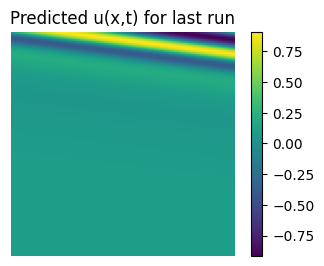

In [ ]:
import os
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm
import argparse
from util import get_data, get_n_params, make_time_sequence
from model_dict import get_model

# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Parse arguments
parser = argparse.ArgumentParser(description='Training PINN with Hyperparameter Search')
parser.add_argument('--device', type=str, default='cpu', help='Compute device (e.g. "cpu" or "cuda:0")')
args, unknown = parser.parse_known_args()  # Use parse_known_args to avoid Jupyter extra args
device = args.device

# PDE Setup: u_t + 50 u_x = 0
# Analytical solution: u(x,t) = sin(x - 50 t)
def u_exact(x, t):
    return np.sin(x - 50*t)

# Load data
res, b_left, b_right, b_upper, b_lower = get_data([0, 2*np.pi],[0,1],101,101)
res_test, _, _, _, _ = get_data([0, 2*np.pi],[0,1],101,101)

# Convert data to tensors
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

# Parameter grid
param_grid = {
    "learning_rate": [0.001, 0.01, 0.02],
    "hidden_layers": [2, 4],
    "hidden_units": [128, 256],
}

max_epochs = 500

results = []

for lr, hl, hu in product(param_grid["learning_rate"], param_grid["hidden_layers"], param_grid["hidden_units"]):
    print(f"\nTraining with hyperparams: learning_rate={lr}, hidden_layers={hl}, hidden_units={hu}")

    # Initialize the PINN model
    ModelClass = get_model("PINN")  # Only PINN model
    model = ModelClass(in_dim=2, hidden_dim=hu, out_dim=1, num_layer=hl).to(device)
    model.apply(init_weights)

    # Use LBFGS optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20, history_size=50, line_search_fn='strong_wolfe')

    loss_track = []

    for epoch in tqdm(range(max_epochs)):
        def closure():
            optimizer.zero_grad()
            pred_res = model(x_res, t_res)
            pred_left = model(x_left, t_left)
            pred_right = model(x_right, t_right)
            pred_upper = model(x_upper, t_upper)
            pred_lower = model(x_lower, t_lower)

            # PDE residual calculation
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res),
                                      retain_graph=True, create_graph=True)[0]

            # PDE: u_t + 50 u_x = 0
            loss_res = torch.mean((u_t + 50*u_x)**2)
            # Periodic BC in x: u(0,t)=u(2π,t)
            loss_bc = torch.mean((pred_upper - pred_lower)**2)
            # Initial condition: u(x,0)=sin(x)
            loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0]))**2)

            loss = loss_res + loss_bc + loss_ic
            loss.backward(retain_graph=True)
            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
            return loss

        optimizer.step(closure)

    # Extract final losses
    final_loss_res = loss_track[-1][0]
    final_loss_bc = loss_track[-1][1]
    final_loss_ic = loss_track[-1][2]
    final_loss_sum = final_loss_res + final_loss_bc + final_loss_ic

    # Evaluate on test data
    res_test_tensor = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
    x_test, t_test = res_test_tensor[:,0:1], res_test_tensor[:,1:2]
    with torch.no_grad():
        pred = model(x_test, t_test).cpu().numpy().reshape(101,101)

    u = u_exact(res_test[:,0], res_test[:,1]).reshape(101,101)
    rl1 = np.sum(np.abs(u - pred))/np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u - pred)**2)/np.sum(u**2))

    print(f"Hyperparams: lr={lr}, hl={hl}, hu={hu}")
    print('Final Loss Res: {:.6f}, Loss BC: {:.6f}, Loss IC: {:.6f}, Loss Sum: {:.6f}'.format(
        final_loss_res, final_loss_bc, final_loss_ic, final_loss_sum))
    print('relative L1 error: {:.6f}'.format(rl1))
    print('relative L2 error: {:.6f}'.format(rl2))

    # Store results
    results.append({
        "learning_rate": lr,
        "hidden_layers": hl,
        "hidden_units": hu,
        "final_loss_res": final_loss_res,
        "final_loss_bc": final_loss_bc,
        "final_loss_ic": final_loss_ic,
        "final_loss_sum": final_loss_sum,
        "relative_L1_error": rl1,
        "relative_L2_error": rl2
    })

# Save results to CSV
results_df = pd.DataFrame(results)
if not os.path.exists("./results/"):
    os.makedirs("./results/")
results_df.to_csv("./results/hyperparameter_search_results.csv", index=False)
print("Results saved to ./results/hyperparameter_search_results.csv")

# Optional: Save final model and visualize last run
torch.save(model.state_dict(), "./results/final_model.pt")

plt.figure(figsize=(4,3))
plt.imshow(pred, aspect='equal')
plt.title('Predicted u(x,t) for last run')
plt.colorbar()
plt.tight_layout()
plt.axis('off')
plt.savefig("./results/final_pred.png", bbox_inches='tight')
print("Saved final prediction image and final model.")
